In [1]:
import aopy
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from db import dbfunctions as db
from IPython.display import display, Markdown,HTML
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
colorlist = ['r','g','b','c','m','y']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# EVENT CODE
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CURSOR_ENTER_PERIPHERAL_TARGET = list(range(81,89))
PERIPHERAL_TARGET_ON = list(range(17,25))
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
PAUSE = 254
TIME_ZERO = 238
TRIAL_END = 239
END_TRIAL_CODE = TRIAL_END
def get_trial_segment(traj, fs, time_start, time_end):
    
    ntr = time_start.shape[0]
    t_axis = np.arange(traj.shape[0])/fs
    
    segmented_traj = []
    for itr in range(ntr):
        win = (t_axis>=time_start[itr])&(t_axis<=time_end[itr])
        segmented_traj.append(traj[win,:])
        
    segmented_traj = np.array(segmented_traj, 'object')
    return segmented_traj

def get_preproc_kinematic_segment(proc_data, samplerate, event_code,event_timestamp, TRIAL_START, TRIAL_END, trial_filter):
    trial_segments, trial_times = aopy.postproc.get_trial_segments(event_code,event_timestamp,TRIAL_START, TRIAL_END)
    trajectories = np.array(aopy.postproc.get_data_segments(proc_data, trial_times, samplerate), dtype='object')
    trial_segments = np.array(trial_segments, dtype='object')
    trial_times = np.array(trial_times, dtype='object')
    success_trials = [trial_filter(t) for t in trial_segments]
    
    return trajectories[success_trials],trial_segments[success_trials],trial_times[success_trials]

def get_cursor_leave_center_time(data, times, samplerate, target_radius):
    '''
    Compute the time when the cursor leaves the center target radius
    
    Args:
        traj (ntrials list of (nt,2)): x,y trajectory data
        times (ntrials list of timestamps): The first and the last timestamp of each list must be trial start time and reward time
        target_radius (float): the radius of the center target
        
    Returns:
        cursor_leave_center_time (ntrials list): the time when the cursor leaves the center target radius
    '''
    ntr = len(data)
    cursor_leave_center_time = []
    
    for itr in range(ntr):
        t_axis = np.arange(data[itr].shape[0])/samplerate
        
        dist = np.sqrt(data[itr][:,0]**2 + data[itr][:,1]**2)
        leave_idx = np.where(dist>target_radius)[0]
        temp = t_axis[leave_idx]
        cursor_leave_center_time.append(temp[0])
    
    return cursor_leave_center_time

def get_main_saccade(onset_target, offset_target, onset_event, offset_event, target_idx):
    '''
    Finds a main saccade to look at the peripheral target from the center target in a given trial
    
    Args:
        onset_target
        offset_target
        onset_event
        offset_event
        target_idx
        
    Returns:
        saccade_targ
    '''
    saccade_index = np.vstack([onset_target,offset_target])
    saccade_event = np.vstack([onset_event,offset_event])

    nsaccade = onset_target.shape[0]
    
    saccade_for_target = np.array([0, int(target_idx)]) # The saccade for the peripheral target
    event_for_gocue = np.array([32,32])

    saccade_for_target_idx = -1
    for isaccade in range(nsaccade):
        sac_idx = saccade_index[:,isaccade]
        sac_event = saccade_event[:,isaccade]

        # find a saccade for the peripheral target after gocue
        #if np.all(sac_idx == saccade_for_target) & np.all(sac_event == event_for_gocue):#& (sum(onset_event == 32) ==1):
        if np.all(offset_target[isaccade] == int(target_idx)):# & np.all(offset_event[isaccade] == 32):
            saccade_for_target_idx = isaccade
    
    return saccade_for_target_idx

def detect_movement_onset(cursor_traj, fs, trial_start, target_onset, gocue, numsd=3.0):
    '''
    Compute movement (s) onset when cursor speed crosses threshold based on mean and standard deviation in baseline period.
    Baseline is defined as the period between target onset and gocue because speed still exists soon after the cursor enters the center target.
    
    args:
        cursor_traj (ntr) : cursor trajectory
        fs (float) : sampling rate in Hz
        trial_start (ntr) : trial start time in sec
        target_onset (ntr) : target onset in sec
        gocue (ntr) : gocue (the time when the center target disappears) in time
        
    returns:
        movement_onset (ntr)
    '''
    
    target_from_start = target_onset - trial_start
    gocue_from_start = gocue - trial_start
    dt = 1/fs
    
    movement_onset = []
    for itr in range(cursor_traj.shape[0]):
        # compute speed
        dist = np.linalg.norm(cursor_traj[itr],axis=1)
        speed = np.gradient(dist, dt) # in (cm/s)
        
        # compute threshold based on mean and std in baseline
        t_cursor = np.arange(dist.shape[0])*dt
        baseline_idx = (t_cursor<gocue_from_start[itr]) & (t_cursor>target_from_start[itr])
        baseline_speed = np.mean(speed[baseline_idx])
        baseline_std = np.std(speed[baseline_idx],ddof=1)
        thr = baseline_speed + numsd*baseline_std
        
        # get movement onset
        movement_onset.append(t_cursor[np.where((speed>thr)&(t_cursor>target_from_start[itr]))[0][0]])
        
    return np.array(movement_onset)


def get_minimum_trials_per_target(target_idx, cond_mask):
    
    # Get the minimum number of trials per target after restricting trials
    num_trial_targ = []
    for itarget in np.unique(target_idx):
        num_trial_targ.append(sum(target_idx[cond_mask] == itarget))
    min_trial = min(num_trial_targ)
    
    return min_trial

def get_conditioned_trials_per_target(target_idx, cond_mask, min_trial, replacement=False, seed=None):
    '''
    Get trial index to choose the same number of trials per target in removing trials by a certain condition
    
    Args:
        target_index (ntr: int): target index
        cond_mask (ntr: bool): condition to remove trials
        replacement (bool): whether to allow replacement in choosing trials. This can be used for bootstrapping.
        
    Returns:
        trial_index (ntrial: bool): trial index to extract the same number of conditioned trials for each target
        
    '''
    if seed:
        np.random.seed(seed)
        
    # Get trial index to get the same number of trials per target
    tmp = []
    for itarget in np.unique(target_idx):
        trial_mask_targ = np.where(cond_mask * (target_idx == itarget))[0] # get conditioned trial index for each target

        if trial_mask_targ.size:
            tmp = np.concatenate([tmp, np.random.choice(trial_mask_targ, min_trial, replace=replacement)])

    trial_mask = np.array([int(a) for a in tmp]) # convert float to int
    trial_mask = np.random.permutation(trial_mask) # because trial mask is well organized in the order of target number
    
    return trial_mask

def classify_targ_lda2(band_data, cond_label, n_splits=10):
    kf = KFold(n_splits=n_splits)
    lda = LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')
       
    # LDA at each single electrode
    ntr,nband,nch = band_data.shape
    pred_Y_ch = []
    true_Y_ch = []
    for ich in range(nch):
        X = band_data[:,:,ich].reshape(ntr,-1)
        Y = cond_label
        if ich == 0:
            weights = np.zeros((n_splits, nch, nband))
            
        pred_Y = []
        true_Y = []
        for ifold, (train_idx, test_idx) in enumerate(kf.split(X)):
            Xtrain,Xtest = X[train_idx,:],X[test_idx,:]
            Ytrain,Ytest = Y[train_idx],Y[test_idx]
            
            lda.fit( Xtrain - np.mean(Xtrain,axis=0), Ytrain)
            reshaped_weights = lda.coef_.reshape(-1,nband)
            weights[ifold, ich, :] = np.sum(np.abs(reshaped_weights),axis=0)

            pred_Y.append(lda.predict( Xtest - np.mean(Xtrain,axis=0)))
            true_Y.append(Ytest)
        pred_Y_ch.append(pred_Y)
        true_Y_ch.append(true_Y)
    return pred_Y_ch, true_Y_ch, weights

def get_relevant_saccade_idx(onset_target, offset_target, saccade_distance, target_idx):
    '''
    Finds a relevant saccade index which is for looking at the peripheral target from the center target in a given trial
    onset_target and offset_target can be obtained by get_saccade_target_index.
    If there are multiple relevant saccades, choose the saccade whose distance is the largest among other saccades
    If there is no relevant saccades, the saccade index becomes -1
    
    Args:
        onset_target (nsaccade): target index at saccade start in a given trial
        offset_target (nsaccade): target index at saccade end in a given trial  
        saccade_distance (nsaccade): eye movement distance in a given trial
        target_idx (int): target index in a given trial
        
    Returns:
        (int): relevant saccade index with the largest distance among saccades. index becomes -1 if there is no relevant saccades.
    '''
    
    # Get saccade target index when saccade starts and ends
    saccade_target_index = np.vstack([onset_target,offset_target])
    
    # Get saccade target index that relevant saccade (saccade for the peripheral target) should have
    relevant_saccade_target_idx = np.array([0, int(target_idx)])

    dist = []
    saccade_idx = []
    relevant_saccade_idx = -1
    
    # Check if each saccade is relevant or not
    for isaccade in range(onset_target.shape[0]):

        # find a saccade for the peripheral target
        if np.all(saccade_target_index[:,isaccade] == relevant_saccade_target_idx):
            saccade_idx.append(isaccade) # get saccade index about potential relevant saccades
            dist.append(saccade_distance[isaccade]) # get eye movement distance about potential relevant saccades
    
    # Get a relevant saccade index with the largest distance
    if len(saccade_idx):
        relevant_saccade_idx = saccade_idx[np.argmax(dist)]  
        
    return relevant_saccade_idx

/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


In [42]:
data_dir = '/data/raw'
preproc_dir = '/data/preprocessed'

subject = 'beignet'
time_before = .05
time_after = 0.05
offset = 0.3
success_rate_window = 25
# flag = 'movement'
# flag = 'reward'
# flag = 'gocue'
# flag = 'acquire'
flag = 'target'

if subject == 'beignet':
    ex_date_list = [(2022,6,28)]
    num_sd_mv = 5.0
    num_sd = 2.5 # for saccade detection
else:
    #ex_date_list = [(2023,7,24)]
    # ex_date_list = [(2023,7,26)]
    # ex_date_list = [(2023,7,25),(2023,7,26),(2023,7,27),(2023,7,28),(2023,7,29),(2023,7,30),(2023,7,31),(2023,8,1),(2023,8,2),(2023,8,3)]
    ex_date_list = [(2024,1,2), (2024,1,3)] # Eye constrained
    # ex_date_list = [(2023,12,2),(2023,12,4),(2023,12,5),(2023,12,8),(2023,12,9)] # Not eye constrained
    num_sd_mv = 3.0
    num_sd = 1 # for saccade detection
    
downsamplerate = 1000 # for saccade detection

sac_radius = 3.0
min_intersaccade = 0.02 # for saccade detection

data_list = []
import ast
for date in ex_date_list:
    entries = db.get_task_entries(subject__name=subject, date=date, task__name='manual control')
    for entry in entries:
        params = entry.task_params
        
        if (subject == 'affi')*(ex_date_list==[(2024,1,2),(2024,1,3)]):
            if ('record_headstage' in params)*('rand_delay' in params)*('show_eye_pos' in params):
                d = ast.literal_eval(entry.report)
                if (params['rand_delay'][-1] >= 0.6)|(params['multi_hold_time'][-1] == 0.175):
                    if d['n_success_trials'] >= 50:
                        data_list.append(entry)
                        print(entry.report, params['rand_delay'], params['multi_hold_time'])
                        
        elif (subject == 'affi'):
            if ('record_headstage' in params)*('rand_delay' in params):
                d = ast.literal_eval(entry.report)
                if (params['rand_delay'][-1] >= 0.6):
                    if d['n_success_trials'] >= 50:
                        data_list.append(entry)
                        print(entry.report, params['rand_delay'])
                        
        elif subject == 'beignet':
            if ('record_headstage' in params)*('rand_delay' in params):
                if params['rand_delay'] == [0.1,0.6]:
                    data_list.append(entry)
                    print(entry.report)          

print(data_list)
print(len(data_list))
#rand_delay = [data.task_params['rand_delay'] for data in data_list1[1:]]
#print(f'Random delay is {rand_delay}')

{"runtime": 2375.984918117523, "n_trials": 915, "n_success_trials": 800}
[2022-06-28 09:47:31.941000: beignet on manual control task, id=5927]
1


In [43]:
bad_id = [13214, 13221, 13224]
data_list = [entry for entry in data_list if entry.id not in bad_id]
print(len(data_list))

1


# Load data

  0%|          | 0/1 [00:00<?, ?it/s]

Bad channels : [ 59 228]
The number of bad channels : 2
(238,)
ratio 0.9625
# relevant saccade trials 770
# All trials 800


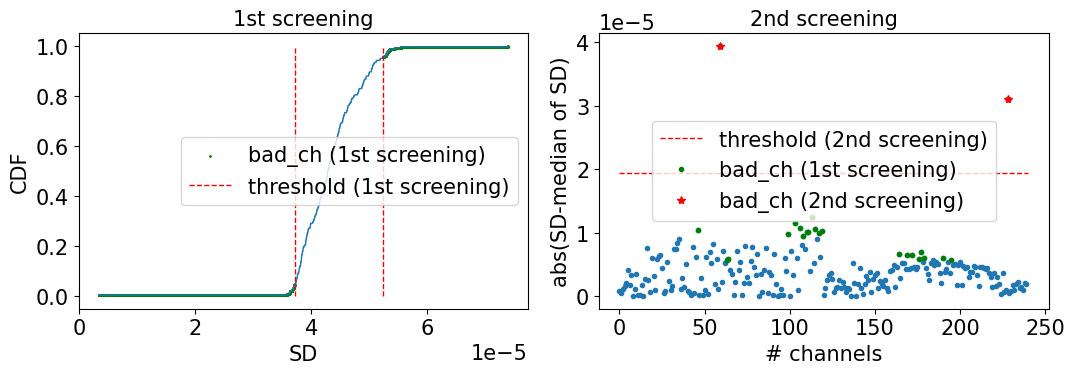

In [44]:
trial_filter = lambda t: REWARD in t # choose only rewarded trials for analysis
elec_pos, acq_ch, elecs = aopy.data.load_chmap(drive_type='ECoG244')

for idx, entry in enumerate(tqdm(data_list)):
    exp_id = entry.id
    exp_date = entry.date.date()
    
    # Load data
    data, metadata = aopy.data.load_preproc_exp_data(preproc_dir, subject, exp_id, exp_date)
    lfp_data, lfp_metadata =  aopy.data.load_preproc_lfp_data(preproc_dir, subject, exp_id, exp_date)
    cursor_traj_tmp, tsegs_tmp = aopy.data.get_kinematic_segments(preproc_dir, subject, exp_id, exp_date, CURSOR_ENTER_CENTER_TARGET, TRIAL_END, trial_filter=trial_filter) 
    segs_tmp, times_tmp = aopy.preproc.base.get_trial_segments_and_times(data['events']['code'], data['events']['timestamp'],CURSOR_ENTER_CENTER_TARGET, TRIAL_END)
    times_tmp = [t for s, t in zip(segs_tmp, times_tmp) if trial_filter(s)]  # get_trial_segments_and_times() does not include a trial filter so doing this outside. 
    eye_data, eye_metadata = aopy.data.load_preproc_eye_data(preproc_dir, subject, exp_id, exp_date)
    target_idx_tmp = np.array([int(seg[1] - CENTER_TARGET_ON ) for seg in tsegs_tmp])
    
    # Collect metadata
    volt_bit = lfp_metadata['voltsperbit']
    FS_cursor = metadata['cursor_interp_samplerate']
    FS_hand = metadata['analog_samplerate']
    FS_eye = eye_metadata['samplerate']
    FS = lfp_metadata['lfp_samplerate']
    target_radius = metadata['target_radius']

    # bad channel detection
    lfp_data = lfp_data[:,acq_ch-1]*volt_bit
    if idx == 0:
        numsd_badch = 5
        bad_ch = aopy.preproc.quality.detect_bad_ch_outliers(lfp_data[:60*FS,:], nbins=10000, thr=0.05, numsd=numsd_badch, debug=True, verbose=True) #bad channels detected from the lfp data in the 1st second
        good_ch =~bad_ch
        target_pos = aopy.data.get_target_locations(preproc_dir, subject, exp_id, exp_date, [0,1,2,3,4,5,6,7,8])  

    # FIR filter
    # order = 20000
    # Wn = [0.1,200]
    # fnq = FS/2
    # print('filtering...')
    # b = signal.firwin(order, Wn, nyq=fnq, pass_zero=False, window='hamming')
    # lfp_filter = signal.filtfilt(b, 1, lfp_data, axis=0)
    # np.save(f'/data/postprocessed/tomo/lfp_filter_{subject}_{exp_date}_{exp_id}',lfp_filter)
    if subject == 'affi':
        lfp_filter_tmp = np.load(f'/data/postprocessed/tomo/lfp_filter_{subject}_{exp_date}_{exp_id}.npy')
    elif subject == 'beignet':
        lfp_filter_tmp = np.load(f'/data/postprocessed/tomo/lfp_filter_{subject}_{exp_date}.npy')

    # Get task event times
    # this sequence works for when trials are aligned to CURSOR_ENTER_CENTER_TARGET to [REWARD, TRIAL_END]
    ntr = len(cursor_traj_tmp)
    trial_start_tmp = np.array([t[0] for t in times_tmp])
    target_onset_tmp = np.array([t[1] for t in times_tmp])
    gocue_time_tmp = np.array([t[2] for t in times_tmp])
    acquire_time_tmp = np.array([t[3] for t in times_tmp]) # corresponds to cursor enter peripheral target 
    reward_time_tmp = np.array([t[4] for t in times_tmp])
    trial_end_tmp = np.array([t[5] for t in times_tmp])
    movement_onset_tmp = aopy.analysis.get_movement_onset(cursor_traj_tmp, 1000, trial_start_tmp, target_onset_tmp, gocue_time_tmp, numsd=3.0, butter_order=4, low_cut=20, thr=5)
    movement_onset_tmp = movement_onset_tmp + trial_start_tmp

    # Get eye trajectories
    if (subject == 'affi')*(ex_date_list==[(2024,1,2),(2024,1,3)]):
        # calibrated_eye_interp = aopy.data.get_interp_kinematics(data, metadata, datatype='calibrated_eye', samplerate=FS_eye) # online eye data
        calibrated_eye_interp = aopy.data.get_interp_task_data(data, metadata, datatype='calibrated_eye', samplerate=FS_eye) # online eye data
        eye_traj_tmp = get_trial_segment(calibrated_eye_interp, FS_eye, trial_start_tmp, trial_end_tmp)
    else:
        eye_traj_tmp, _ = aopy.data.get_kinematic_segments(preproc_dir, subject, exp_id, exp_date, CURSOR_ENTER_CENTER_TARGET, TRIAL_END, trial_filter=trial_filter, datatype='eye')        

    # Calc saccade onset
    saccades_onset_tmp,saccade_onset_tmp,duration_tmp,main_saccade_idx_tmp = [],[],[],[]
    for itr in range(target_idx_tmp.shape[0]):
        if (subject == 'affi')*(ex_date_list==[(2024,1,2),(2024,1,3)]):
            ave_eye_traj = eye_traj_tmp[itr]
        else:
            ave_eye_traj = np.stack([(eye_traj_tmp[itr][:,0]+eye_traj_tmp[itr][:,2])/2, (eye_traj_tmp[itr][:,1]+eye_traj_tmp[itr][:,3])/2]).T
 
        # Filter eye data
        eye_data_filt,_ = aopy.precondition.filter_eye(ave_eye_traj, FS_eye, downsamplerate=downsamplerate)
        
        # Get saccade onset
        onset, duration1, distance1 = aopy.precondition.detect_saccades(eye_data_filt, downsamplerate, num_sd=num_sd)
        
        # Get relevant saccades from the center target to the peripheral target
        onset_pos, offset_pos = aopy.postproc.get_saccade_pos(ave_eye_traj, np.array(onset), np.array(duration1), downsamplerate)
        onset_target, offset_target = aopy.postproc.get_saccade_target_index(onset_pos, offset_pos, target_pos[:,:2], sac_radius)
        onset_event, offset_event = aopy.postproc.get_saccade_event(np.array(onset), np.array(duration1), times_tmp[itr]-times_tmp[itr][0], tsegs_tmp[itr])
        saccade_idx = get_relevant_saccade_idx(onset_target, offset_target, distance1, target_idx_tmp[itr])
        
        onset += times_tmp[itr][0]
        duration_tmp.append(duration1)
        saccades_onset_tmp.append(onset)
        saccade_onset_tmp.append(onset[saccade_idx]) # saccade onset of relevant saccades
        main_saccade_idx_tmp.append(saccade_idx)
        
    saccade_onset_tmp = np.array(saccade_onset_tmp)
    saccades_onset_tmp = np.array(saccades_onset_tmp, dtype=object)
    duration_tmp = np.array(duration_tmp, dtype=object)
    main_saccade_idx_tmp = np.array(main_saccade_idx_tmp)
    
    # Calc trial_align_data
    if flag == 'gocue':
        trial_align_data_tmp = aopy.preproc.trial_align_data(lfp_filter_tmp, gocue_time_tmp, time_before, time_after, FS)
        flag_name = 'gocue'
    elif flag == 'saccade':
        trial_align_data_tmp = aopy.preproc.trial_align_data(lfp_filter_tmp, saccade_onset_tmp, time_before, time_after, FS)
        flag_name = 'saccade onset'
    elif flag == 'target':
        trial_align_data_tmp = aopy.preproc.trial_align_data(lfp_filter_tmp, target_onset_tmp, time_before, time_after, FS)
        flag_name = 'target onset'
    elif flag == 'acquire':
        trial_align_data_tmp = aopy.preproc.trial_align_data(lfp_filter_tmp, acquire_time_tmp, time_before, time_after, FS)
        flag_name = 'acquire'
    elif flag == 'movement':
        trial_align_data_tmp = aopy.preproc.trial_align_data(lfp_filter_tmp, movement_onset_tmp, time_before, time_after, FS)
        flag_name = 'movement'
    elif flag == 'reward':
        trial_align_data_tmp = aopy.preproc.trial_align_data(lfp_filter_tmp, reward_time_tmp, time_before, time_after, FS)
        flag_name = 'reward'
    else:
        print('Use different flag name')
    trial_align_data_tmp = trial_align_data_tmp.transpose(2,0,1)
    
    # Concatenate trials across days
    if idx == 0:
        trial_align_data = trial_align_data_tmp
        trial_start = trial_start_tmp
        target_onset = target_onset_tmp
        gocue_time = gocue_time_tmp
        reward_time = reward_time_tmp
        movement_onset = movement_onset_tmp
        saccade_onset = saccade_onset_tmp
        acquire_time = acquire_time_tmp
        target_idx = target_idx_tmp
        cursor_traj = cursor_traj_tmp
        eye_traj = eye_traj_tmp
        saccades_onset = saccades_onset_tmp
        duration = duration_tmp
        times = times_tmp
        tsegs = tsegs_tmp
        main_saccade_idx = main_saccade_idx_tmp
        lfp_filter = lfp_filter_tmp

    else:
        trial_align_data = np.concatenate([trial_align_data, trial_align_data_tmp], axis=0)
        lfp_filter = np.concatenate([lfp_filter, lfp_filter_tmp],axis=0)
        trial_start = np.concatenate([trial_start, trial_start_tmp])
        target_onset = np.concatenate([target_onset, target_onset_tmp])
        gocue_time = np.concatenate([gocue_time, gocue_time_tmp])
        reward_time = np.concatenate([reward_time, reward_time_tmp])
        movement_onset = np.concatenate([movement_onset, movement_onset_tmp])
        saccade_onset = np.concatenate([saccade_onset, saccade_onset_tmp])
        saccades_onset = np.concatenate([saccades_onset, saccades_onset_tmp])
        duration = np.concatenate([duration, duration_tmp])
        acquire_time = np.concatenate([acquire_time, acquire_time_tmp])
        target_idx = np.concatenate([target_idx, target_idx_tmp])
        cursor_traj = np.concatenate([cursor_traj, cursor_traj_tmp])
        eye_traj = np.concatenate([eye_traj, eye_traj_tmp])
        times = np.concatenate([times, times_tmp])
        tsegs = np.concatenate([tsegs, tsegs_tmp])
        main_saccade_idx = np.concatenate([main_saccade_idx, main_saccade_idx_tmp])
        
      
trial_align_data = trial_align_data[:,:,good_ch]
elec_pos = elec_pos[good_ch]
acq_ch = acq_ch[good_ch]
ntr,nt,nch = trial_align_data.shape
print(acq_ch.shape)
normal_saccade_trial = main_saccade_idx != -1 # When main_saccade_idx == -1, there is no relevant saccades in a trial
print('ratio',normal_saccade_trial.sum()/normal_saccade_trial.shape[0])
print('# relevant saccade trials',normal_saccade_trial.sum())
print('# All trials',normal_saccade_trial.shape[0])

In [45]:
# load spectral power data
target_list = [1,2,3,4,5,6,7,8]
ntarget = len(target_list)

bands = [(0.1,4),(4,8),(8,14),(14,30),(30,80),(80,150)]
nband = len(bands)
band_name = ['delta','theta','alpha','beta','gamma','hgamma']
NW = 0.5
BW = 4 # the number of taper is (2*nw*bw-1)
t_axis = np.linspace(-time_before,time_after,nt)
# print(flag)
spec_flag = flag
# loaded_data = np.load(f'/data/postprocessed/tomo/spec/{subject}_{flag}_{NW}_{BW}_{str(exp_date)}_fir-filt.npz')
loaded_data = np.load(f'/data/postprocessed/tomo/ECoG_mapping/spec/{subject}_{spec_flag}_{NW}_{BW}_{str(exp_date)}.npz')
f_spec = loaded_data['f_spec']
t_spec = loaded_data['t_spec']
spec_band = loaded_data['spec_band']
print(f'{subject}_{flag}_{NW}_{BW}_{str(exp_date)}_fir-filt.npz')

if subject == 'affi':
    elec_pos[:,0] = elec_pos[:,0]*-1
    elec_pos[:,[1,0]] = elec_pos[:,[0,1]]
    

beignet_target_0.5_4_2022-06-28_fir-filt.npz


In [46]:
baseline_start_idx = np.where(t_spec > -1)[0][0]
baseline_stop_idx = np.where(t_spec > -.5)[0][0]
# print(baseline_t_spec[baseline_start_idx], baseline_t_spec[baseline_stop_idx])

In [47]:
baseline_spec_band = spec_band

In [48]:
# Load baseline power data (before target onset)
baseline_flag = 'target'
baseline_data = np.load(f'/data/postprocessed/tomo/ECoG_mapping/spec/{subject}_{baseline_flag}_{NW}_{BW}_{str(exp_date)}.npz')
baseline_t_spec = baseline_data['t_spec']
baseline_spec_band = baseline_data['spec_band']

In [9]:
# Compute relevant saccade and reasonable movement onset trials
target_idx = np.array([t[1]-CENTER_TARGET_ON for t in tsegs])

saccades_onset,saccade_onset,duration,main_saccade_idx = [],[],[],[]
for itr in range(len(eye_traj)):
    ave_eye_traj = np.stack([(eye_traj[itr][:,0]+eye_traj[itr][:,2])/2, (eye_traj[itr][:,1]+eye_traj[itr][:,3])/2]).T
    eye_data_filt = aopy.precondition.filter_eye(ave_eye_traj, FS_eye, downsamplerate=downsamplerate)

    onset, duration1, distance1 = aopy.precondition.detect_saccades(eye_data_filt, downsamplerate, num_sd=num_sd)

    onset_pos, offset_pos = aopy.postproc.get_saccade_pos(ave_eye_traj, np.array(onset), np.array(duration1), downsamplerate)
    onset_target, offset_target = aopy.postproc.get_saccade_target_index(onset_pos, offset_pos, target_pos[:,:2], sac_radius)
    onset_event, offset_event = aopy.postproc.get_saccade_event(np.array(onset), np.array(duration1), times[itr]-times[itr][0], tsegs[itr])
    saccade_idx = get_main_saccade(onset_target, offset_target, onset_event, offset_event, target_idx[itr])

    onset += times[itr][0]
    duration.append(duration1)
    saccades_onset.append(onset)
    saccade_onset.append(onset[saccade_idx])
    main_saccade_idx.append(saccade_idx)

saccade_onset = np.array(saccade_onset)
saccades_onset = np.array(saccades_onset, dtype=object)
duration = np.array(duration, dtype=object)
main_saccade_idx = np.array(main_saccade_idx)

# get trials with relevant saccades
normal_saccade_trial = main_saccade_idx != -1

# get trials with reasonable movement onset
movement_onset_go = movement_onset - gocue_time
normal_onset_time = movement_onset_go > 0.15

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

# Discrete (LDA) decoding analysis

## All targets

In [ ]:
alignment_flag = 'acquire' # which alignment you use in decoding
target_idx = np.array([t[1]-CENTER_TARGET_ON for t in tsegs])

# Times relative to gocue
target_on_go = target_onset - gocue_time
saccade_onset_go = saccade_onset - gocue_time
cursor_leave_go = cursor_leave_time - gocue_time
acquire_go = acquire_time - gocue_time
reward_go = reward_time - gocue_time

if alignment_flag == 'target':
    t_center = target_on_go
    win = [0.1,0.2]
elif alignment_flag == 'gocue':
    t_center = np.zeros(ntr)
    win = [-0.05,0.05]
elif alignment_flag == 'saccade':
    t_center = saccade_onset_go
    win = [-0.05,0.05]
elif alignment_flag == 'movement':
    t_center = movement_onset_go
    win = [-0.05,0.05]
elif alignment_flag == 'cursor_leave':   
    t_center = cursor_leave_go
    win = [-0.05,0.05]
elif alignment_flag == 'acquire':   
    t_center = acquire_go
    win = [-0.05,0.05]
elif alignment_flag == 'reward':   
    t_center = reward_go
    win = [-0.05,0.05]

# z scoring
z_spec_band = (spec_band - np.mean(spec_band, axis=(0,2),keepdims=True))/(np.std(spec_band, axis=(0,2),keepdims=True,ddof=1))

# Get bad trials
bad_tr = []
for itr in range(ntr):
    time_win = (t_spec >= t_center[itr] + win[0])*(t_spec <= t_center[itr] + win[1])
    itr_data = z_spec_band[[itr],:,:,:]
    tmp = np.mean(itr_data[:,:,time_win,:],axis=2)
    if sum(time_win)==0:
        bad_tr.append(itr)
    if itr == 0:
        z_data_win = tmp
    else:
        z_data_win = np.concatenate([z_data_win, tmp],axis=0)
        
bad_tr = np.array(bad_tr)
print(bad_tr)
if bad_tr.size>0:
    bad_tr_mask = np.zeros(ntr,dtype=bool)
    bad_tr_mask[bad_tr] = True
    good_tr_mask = ~bad_tr_mask
else:
    good_tr_mask = np.ones(ntr,dtype=bool)

trial_restrict_mask = normal_saccade_trial * normal_onset_time * good_tr_mask

In [ ]:
band_idx = -1 # which band you focus
nbs = 300 # number of bootstrapping
n_splits = 5 # number of cross validation
shuffle = False # whether to shuffle target index for permutation test

y_pred_bs = []
y_true_bs = []
weights_bs = []
print(f'{alignment_flag}')
z_single_win = z_data_win[:,[band_idx],:]

min_trial = get_minimum_trials_per_target(target_idx, trial_restrict_mask)
print(min_trial)

for i_bs in tqdm(range(nbs)):
    np.random.seed(i_bs)
    
    # Get trial label with replacement for bootstrapping
    trial_mask = get_conditioned_trials_per_target(target_idx, trial_restrict_mask, min_trial, replacement=True, seed=i_bs)
    trial_mask = np.random.permutation(trial_mask)
    
    # Get data for LDA
    data_win = z_single_win[trial_mask,:,:]
    cond_label = target_idx[trial_mask]
    if shuffle:
        cond_label = np.random.permutation(cond_label)
    
    # Average score (spatial filtering)
    y_pred, y_true, weights = classify_targ_lda2(data_win, cond_label, n_splits)
    y_pred_bs.append(y_pred)
    y_true_bs.append(y_true)
    weights_bs.append(weights)
    
y_pred_bs = np.array(y_pred_bs, 'object')
y_true_bs = np.array(y_true_bs, 'object')
weights_bs = np.array(weights_bs, 'object')

np.savez(f'/data/postprocessed/tomo/Neuropixel_targeting/{subject}_decoding_{alignment_flag}_numbs{nbs}_shuffle_{shuffle}_{band_name[band_idx]}', y_pred_bs=y_pred_bs, y_true_bs=y_true_bs, weights_bs=weights_bs)

In [ ]:
# load bootstrapping data
nbs = 300
n_splits = 5
band_idx = -1
alignment_flag = 'acquire'
loaded_data = np.load(f'/data/postprocessed/tomo/Neuropixel_targeting/{subject}_decoding_{alignment_flag}_numbs{nbs}_shuffle_{shuffle}_{band_name[band_idx]}.npz',allow_pickle=True)
y_pred_bs = loaded_data['y_pred_bs']
y_true_bs = loaded_data['y_true_bs']
weights_bs = loaded_data['weights_bs']

In [ ]:
accuracy_ch = np.zeros((nbs, nch))
for ibs in tqdm(range(nbs)):
    for ich in range(nch):
        
        accuracy_fold = []
        for ifold in range(n_splits):
            accuracy_fold.append(accuracy_score(y_true_bs[ibs][ich][ifold], y_pred_bs[ibs][ich][ifold]))
        
        accuracy_ch[ibs,ich] = np.mean(accuracy_fold)
        
m_accuracy_bs = np.mean(accuracy_ch,axis=0)

In [ ]:
print(elec_pos.shape)

In [ ]:
# Average accuracy across neighboring channels
m_accuracy_ch = np.zeros(nch)
dist = aopy.utils.calc_euclid_dist_mat(elec_pos)
for ich in range(dist.shape[0]):
    ave_idx = (dist[:,ich] <= 1.3)#0.75, 1.3
    m_accuracy_ch[ich] = np.nanmean(m_accuracy_bs[ave_idx])   

# Show data
fig,ax=plt.subplots(figsize=(7,5),tight_layout=True)
xy = [elec_pos[:,0], elec_pos[:,1]]
da_map = aopy.visualization.get_data_map(m_accuracy_ch,xy[0],xy[1])
da_map[0,0],da_map[0,1],da_map[1,0],da_map[0,-1],da_map[0,-2],da_map[1,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
da_map[-1,0],da_map[-1,1],da_map[-2,0],da_map[-1,-1],da_map[-1,-2],da_map[-2,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
im = aopy.visualization.plot_spatial_map(da_map, xy[0], xy[1], ax=ax, cmap='Blues')
im.norm.vmin = 1/8
im.norm.vmax = np.nanmax(m_accuracy_ch)

cbar = fig.colorbar(im, ax=ax, orientation='vertical',fraction=0.046, pad=0.04)
ax.set(xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[])
fig.show()
np.savez(f'/data/postprocessed/tomo/Neuropixel_targeting/{subject}_{alignment_flag}_decoding_accuracy_{band_name[band_idx]}', da=m_accuracy_ch, elec_pos=elec_pos)

In [ ]:
alignment_list = ['gocue','movement','acquire']
nalignment = len(alignment_list)
band_idx = 0
shuffle=False

accuracy_alignment = np.zeros((nalignment,nbs, nch))
for idx, alignment_flag in enumerate(alignment_list):
    loaded_data = np.load(f'/data/postprocessed/tomo/Neuropixel_targeting/{subject}_decoding_{alignment_flag}_numbs{nbs}_shuffle_{shuffle}_{band_name[band_idx]}.npz',allow_pickle=True)
    y_pred_bs = loaded_data['y_pred_bs']
    y_true_bs = loaded_data['y_true_bs']
    #weights_bs = loaded_data['weights_bs']

    for ibs in tqdm(range(nbs)):
        for ich in range(nch):
            
            accuracy_fold = []
            for ifold in range(n_splits):
                accuracy_fold.append(accuracy_score(y_true_bs[ibs][ich][ifold], y_pred_bs[ibs][ich][ifold]))
                
            accuracy_alignment[idx,ibs,ich] = np.mean(accuracy_fold)

In [ ]:
alignment_list = ['gocue','movement','acquisition']
dist = aopy.utils.calc_euclid_dist_mat(elec_pos)
xy = [elec_pos[:,0], elec_pos[:,1]]
m_accuracy_bs = np.mean(accuracy_alignment,axis=1) # mean across bootstrapping samples

# Average accuracy across neighboring channels
m_accuracy_ch = np.zeros((nalignment,nch))
for ich in range(dist.shape[0]):
    ave_idx = (dist[:,ich] <= 1.3)#0.75, 1.3
    m_accuracy_ch[:,ich] = np.nanmean(m_accuracy_bs[:,ave_idx],axis=1)   

fig,ax=plt.subplots(ncols=nalignment,figsize=(9,3),tight_layout=True)
for idx in range(nalignment):
    da_map = aopy.visualization.get_data_map(m_accuracy_ch[idx,:],xy[0],xy[1])
    da_map[0,0],da_map[0,1],da_map[1,0],da_map[0,-1],da_map[0,-2],da_map[1,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    da_map[-1,0],da_map[-1,1],da_map[-2,0],da_map[-1,-1],da_map[-1,-2],da_map[-2,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    im = aopy.visualization.plot_spatial_map(da_map, xy[0], xy[1], ax=ax[idx], cmap='Blues')
    im.norm.vmin = 1/8
    im.norm.vmax = np.nanmax(m_accuracy_ch)
    ax[idx].set(xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[],title=f'{alignment_list[idx]}')


fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([1., 0.15, 0.011, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical',fraction=0.046, pad=0.04)
fig.show()

## Contralateral and ipsilateral target decoding

In [ ]:
## Show decoding accuracy in different time windows
target_idx = np.array([t[1]-CENTER_TARGET_ON for t in tsegs])
alignment_flag = 'reward'
n_splits = 5

# Aligne timings
target_on_go = target_onset - gocue_time
saccade_onset_go = saccade_onset - gocue_time
cursor_leave_go = cursor_leave_time - gocue_time
reward_go = reward_time - gocue_time

# Prepare data
if alignment_flag == 'target':
    t_center = target_on_go
    win = [0.1,0.2]
elif alignment_flag == 'gocue':
    t_center = np.zeros(ntr)
    win = [-0.05,0.05]
elif alignment_flag == 'saccade':
    t_center = saccade_onset_go
    win = [-0.05,0.05]
elif alignment_flag == 'movement':
    t_center = movement_onset_go
    win = [-0.05,0.05]
elif alignment_flag == 'cursor_leave':   
    t_center = cursor_leave_go
    win = [-0.05,0.05]
elif alignment_flag == 'reward':   
    t_center = reward_go
    win = [-0.05,0.05]

# Preprocess data
#z_spec_band = stats.zscore(spec_band,axis=2)   
z_spec_band = (spec_band - np.mean(spec_band, axis=(0,2),keepdims=True))/(np.std(spec_band, axis=(0,2),keepdims=True,ddof=1))

bad_tr = []
for itr in range(ntr):
    time_win = (t_spec >= t_center[itr] + win[0])*(t_spec <= t_center[itr] + win[1])
    itr_data = z_spec_band[[itr],:,:,:]
    tmp = np.mean(itr_data[:,:,time_win,:],axis=2)
    if sum(time_win)==0:
        bad_tr.append(itr)
    if itr == 0:
        z_data_win = tmp
    else:
        z_data_win = np.concatenate([z_data_win, tmp],axis=0)

bad_tr2 = []
for itr in range(z_spec_band.shape[0]):
    if np.any(np.isnan(z_spec_band[itr,:,:])):
        bad_tr2.append(itr)

bad_tr = np.concatenate([bad_tr,bad_tr2])
bad_tr = np.array([int(a) for a in bad_tr])
print(bad_tr)

if bad_tr.size>0:
    bad_tr_mask = np.zeros(ntr,dtype=bool)
    bad_tr_mask[bad_tr] = True
    good_tr_mask = ~bad_tr_mask
else:
    good_tr_mask = np.ones(ntr,dtype=bool)

trial_restrict_mask = normal_saccade_trial * normal_onset_time * good_tr_mask

In [ ]:
decoding_flag = 'contra'
shuffle = False
nbs = 300
band_idx = -1

y_pred_bs = []
y_true_bs = []
weights_bs = []

z_single_win = z_data_win[:,[band_idx],:]
print(f'{alignment_flag}')

if decoding_flag == 'contra':
    partial_target = [2,3,4]
else:
    partial_target = [6,7,8]

# get minimum number of trials for each target in both contralateral and ipsilateral targets  
contra_ipsi_target_mask = (target_idx == 2)|(target_idx == 3)|(target_idx == 4)|(target_idx == 6)|(target_idx == 7)|(target_idx == 8)
contra_ipsi_cond_mask = trial_restrict_mask * contra_ipsi_target_mask
min_trial = get_minimum_trials_per_target(target_idx[contra_ipsi_cond_mask], contra_ipsi_cond_mask[contra_ipsi_cond_mask])
print(min_trial)

# mask for conditioning trials
lateral_mask = (target_idx == partial_target[0])|(target_idx == partial_target[1])|(target_idx == partial_target[2])
cond_mask = trial_restrict_mask*lateral_mask

for i_bs in tqdm(range(nbs)):
    np.random.seed(i_bs)
    
    # Get trial label with replacement for bootstrapping
    trial_mask = get_conditioned_trials_per_target(target_idx, cond_mask, min_trial, replacement=True, seed=i_bs)
    
    # Get data for LDA
    data_win = z_single_win[trial_mask,:,:]
    cond_label = target_idx[trial_mask]
    if shuffle:
        cond_label = np.random.permutation(cond_label)
        
    # Average score (spatial filtering)
    y_pred, y_true, weights = classify_targ_lda2(data_win, cond_label, n_splits)
    y_pred_bs.append(y_pred)
    y_true_bs.append(y_true)
    weights_bs.append(weights)
    
y_pred_bs = np.array(y_pred_bs, 'object')
y_true_bs = np.array(y_true_bs, 'object')
weights_bs = np.array(weights_bs, 'object')

np.savez(f'/data/postprocessed/tomo/{subject}_decoding_{alignment_flag}_{decoding_flag}_numbs{nbs}_shuffle_{shuffle}_{band_name[band_idx]}', \
    y_pred_bs=y_pred_bs, y_true_bs=y_true_bs, weights_bs=weights_bs)

#############################################################
##### Ipsilateral decoding
#############################################################

decoding_flag = 'ipsi'
y_pred_bs = []
y_true_bs = []
weights_bs = []
print(f'{alignment_flag}')

if decoding_flag == 'contra':
    partial_target = [2,3,4]
else:
    partial_target = [6,7,8]

# get minimum number of trials for each target in both contralateral and ipsilateral targets  
contra_ipsi_target_mask = (target_idx == 2)|(target_idx == 3)|(target_idx == 4)|(target_idx == 6)|(target_idx == 7)|(target_idx == 8)
contra_ipsi_cond_mask = trial_restrict_mask * contra_ipsi_target_mask
min_trial = get_minimum_trials_per_target(target_idx[contra_ipsi_cond_mask], contra_ipsi_cond_mask[contra_ipsi_cond_mask])
print(min_trial)

# mask for conditioning trials
lateral_mask = (target_idx == partial_target[0])|(target_idx == partial_target[1])|(target_idx == partial_target[2])
cond_mask = trial_restrict_mask*lateral_mask

for i_bs in tqdm(range(nbs)):
    np.random.seed(i_bs)
    
    # Get trial label with replacement for bootstrapping
    trial_mask = get_conditioned_trials_per_target(target_idx, cond_mask, min_trial, replacement=True, seed=i_bs)
    
    # Get data for LDA
    data_win = z_single_win[trial_mask,:,:]
    cond_label = target_idx[trial_mask]
    if shuffle:
        cond_label = np.random.permutation(cond_label)
        
    # Average score (spatial filtering)
    y_pred, y_true, weights = classify_targ_lda2(data_win, cond_label, n_splits)
    y_pred_bs.append(y_pred)
    y_true_bs.append(y_true)
    weights_bs.append(weights)
    
y_pred_bs = np.array(y_pred_bs, 'object')
y_true_bs = np.array(y_true_bs, 'object')
weights_bs = np.array(weights_bs, 'object')

np.savez(f'/data/postprocessed/tomo/{subject}_decoding_{alignment_flag}_{decoding_flag}_numbs{nbs}_shuffle_{shuffle}_{band_name[band_idx]}', \
    y_pred_bs=y_pred_bs, y_true_bs=y_true_bs, weights_bs=weights_bs)

In [ ]:
# Contralateral and ipsilateral accuracy
nbs = 300
alignment_list = ['movement','reward']
nalignment = len(alignment_list)
band_idx = -1

accuracy_alignment = np.zeros((4, nalignment, nbs, nch))
for idx, alignment_flag in enumerate(alignment_list):
    loaded_data = np.load(f'/data/postprocessed/tomo/{subject}_decoding_{alignment_flag}_contra_numbs{nbs}_shuffle_False_{band_name[band_idx]}.npz',allow_pickle=True)
    y_pred_bs_contra = loaded_data['y_pred_bs']
    y_true_bs_contra = loaded_data['y_true_bs']

    loaded_data = np.load(f'/data/postprocessed/tomo/{subject}_decoding_{alignment_flag}_contra_numbs{nbs}_shuffle_True_{band_name[band_idx]}.npz',allow_pickle=True)
    y_pred_bs_contra_shuffle = loaded_data['y_pred_bs']
    y_true_bs_contra_shuffle = loaded_data['y_true_bs']
        
    loaded_data = np.load(f'/data/postprocessed/tomo/{subject}_decoding_{alignment_flag}_ipsi_numbs{nbs}_shuffle_False_{band_name[band_idx]}.npz',allow_pickle=True)
    y_pred_bs_ipsi = loaded_data['y_pred_bs']
    y_true_bs_ipsi = loaded_data['y_true_bs']

    loaded_data = np.load(f'/data/postprocessed/tomo/{subject}_decoding_{alignment_flag}_ipsi_numbs{nbs}_shuffle_True_{band_name[band_idx]}.npz',allow_pickle=True)
    y_pred_bs_ipsi_shuffle = loaded_data['y_pred_bs']
    y_true_bs_ipsi_shuffle = loaded_data['y_true_bs']
        
    for ibs in tqdm(range(nbs)):
        for ich in range(nch):
            
            accuracy_fold_contra = []
            accuracy_fold_ipsi = []
            accuracy_fold_contra_shuffle = []
            accuracy_fold_ipsi_shuffle = []
            for ifold in range(n_splits):
                accuracy_fold_contra.append(accuracy_score(y_true_bs_contra[ibs][ich][ifold], y_pred_bs_contra[ibs][ich][ifold]))
                accuracy_fold_ipsi.append(accuracy_score(y_true_bs_ipsi[ibs][ich][ifold], y_pred_bs_ipsi[ibs][ich][ifold]))
                accuracy_fold_contra_shuffle.append(accuracy_score(y_true_bs_contra_shuffle[ibs][ich][ifold], y_pred_bs_contra_shuffle[ibs][ich][ifold]))
                accuracy_fold_ipsi_shuffle.append(accuracy_score(y_true_bs_ipsi_shuffle[ibs][ich][ifold], y_pred_bs_ipsi_shuffle[ibs][ich][ifold]))
                
            accuracy_alignment[0,idx,ibs,ich] = np.mean(accuracy_fold_contra)
            accuracy_alignment[1,idx,ibs,ich] = np.mean(accuracy_fold_ipsi)
            accuracy_alignment[2,idx,ibs,ich] = np.mean(accuracy_fold_contra_shuffle)
            accuracy_alignment[3,idx,ibs,ich] = np.mean(accuracy_fold_ipsi_shuffle)

In [ ]:
alpha = 0.95
dist = aopy.utils.calc_euclid_dist_mat(elec_pos)
xy = [elec_pos[:,0], elec_pos[:,1]]
m_accuracy_bs = np.mean(accuracy_alignment,axis=2) # mean across bootstrapping samples

# Compute significance
not_significant_contra = np.zeros((nalignment,nch),dtype='bool')
for idx in range(nalignment):
    confidence_contra = []
    for ich in range(nch):
        count, bins_count = np.histogram(accuracy_alignment[2,idx,:,ich], bins=50)
        bin_edge = bins_count[1:] - np.diff(bins_count)[0]
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        confidence_contra.append(bin_edge[np.where(cdf<alpha)[0][-1]])
    confidence_contra = np.array(confidence_contra) # nch array
    not_significant_contra[idx,:] = confidence_contra > m_accuracy_bs[0,idx,:]

not_significant_ipsi = np.zeros((nalignment,nch),dtype='bool')
for idx in range(nalignment):
    confidence_ipsi = []
    for ich in range(nch):
        count, bins_count = np.histogram(accuracy_alignment[3,idx,:,ich], bins=50)
        bin_edge = bins_count[1:] - np.diff(bins_count)[0]
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        confidence_ipsi.append(bin_edge[np.where(cdf<alpha)[0][-1]])
    confidence_ipsi = np.array(confidence_ipsi) # nch array
    not_significant_ipsi[idx,:] = confidence_ipsi > m_accuracy_bs[1,idx,:]
    
not_significant = not_significant_contra# + not_significant_ipsi
print(not_significant.shape)

# TODO add another criteria to remove channels

In [ ]:
ipsi_idx = 0
dist = aopy.utils.calc_euclid_dist_mat(elec_pos)
xy = [elec_pos[:,0], elec_pos[:,1]]
m_accuracy_bs = np.mean(accuracy_alignment[ipsi_idx,:,:,:],axis=1) # mean across bootstrapping samples

# Compute significance
# not_significant_ch = np.zeros((nalignment,nch),dtype='bool')
# for idx in range(nalignment):
#     significance = []
#     for ich in range(nch):
#         count, bins_count = np.histogram(accuracy_alignment[ipsi_idx,idx,:,ich], bins=50)
#         bin_edge = bins_count[1:] - np.diff(bins_count)[0]
#         pdf = count / sum(count)
#         cdf = np.cumsum(pdf)
#         significance.append(bin_edge[np.where(cdf<0.05)[0][-1]])
#     significance = np.array(significance) # nch array
#     not_significant_ch[idx,:]  = 1/3 > significance
#     m_accuracy_bs[idx,not_significant_ch[idx,:]] = np.nan

m_accuracy_ch = np.zeros((nalignment,nch))
for ich in range(dist.shape[0]):
    ave_idx = (dist[:,ich] <= 1.3)#0.75, 1.3
    m_accuracy_ch[:,ich] = np.nanmean(m_accuracy_bs[:,ave_idx],axis=1)   

fig,ax=plt.subplots(ncols=nalignment,figsize=(12,4),tight_layout=True)
for idx in range(nalignment):
    m_accuracy_ch[idx,not_significant_contra[idx,:]] = np.nan
    da_map = aopy.visualization.get_data_map(m_accuracy_ch[idx,:],xy[0],xy[1])
    da_map[0,0],da_map[0,1],da_map[1,0],da_map[0,-1],da_map[0,-2],da_map[1,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    da_map[-1,0],da_map[-1,1],da_map[-2,0],da_map[-1,-1],da_map[-1,-2],da_map[-2,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    im = aopy.visualization.plot_spatial_map(da_map, xy[0], xy[1], ax=ax[idx], cmap='Blues')
    im.norm.vmin = 1/3
    im.norm.vmax = np.nanmax(m_accuracy_ch)

    #ax[ii].set(title=f'{center_list[ii]*1000} ms',xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[])
    ax[idx].set(xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[])


fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([1., 0.15, 0.011, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical',fraction=0.046, pad=0.04)
#fig.colorbar(im, cax=cbar_ax)

fig.show()

In [ ]:
#accuracy_alignment[0,idx,ibs,ich] = np.mean(accuracy_fold_contra)
#accuracy_alignment[1,idx,ibs,ich] = np.mean(accuracy_fold_ipsi)

lateral_idx_bs = (accuracy_alignment[0,:,:,:] - accuracy_alignment[1,:,:,:])/(accuracy_alignment[0,:,:,:] + accuracy_alignment[1,:,:,:])
lateral_idx = np.mean(lateral_idx_bs,axis=1)

not_significant_diff = np.zeros((nalignment,nch),dtype=bool)
for idx in range(nalignbaselinement):
    for ich in range(nch):  
        _, p = stats.ranksums(accuracy_alignment[0,idx,:,ich],accuracy_alignment[1,idx,:,ich])
        not_significant_diff[idx,ich] = p > 0.01
        
print(lateral_idx.shape)
m_lateral_idx = np.zeros(lateral_idx.shape)
for ich in range(dist.shape[0]):
    ave_idx = (dist[:,ich] <= 1.3)#0.75, 1.3
    m_lateral_idx[:,ich] = np.nanmean(lateral_idx[:,ave_idx],axis=1)
    
fig,ax=plt.subplots(ncols=nalignment,figsize=(12,4),tight_layout=True)
for idx in range(nalignment):
    #m_lateral_idx[idx,not_significant_contra[idx,:]] = np.nan
    m_lateral_idx[idx,not_significant_diff[idx,:]] = np.nan
    da_map = aopy.visualization.get_data_map(m_lateral_idx[idx,:],xy[0],xy[1])
    da_map[0,0],da_map[0,1],da_map[1,0],da_map[0,-1],da_map[0,-2],da_map[1,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    da_map[-1,0],da_map[-1,1],da_map[-2,0],da_map[-1,-1],da_map[-1,-2],da_map[-2,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    im = aopy.visualization.plot_spatial_map(da_map, xy[0], xy[1], ax=ax[idx], cmap='bwr')
    im.norm.vmin = -np.nanmax(m_lateral_idx)
    im.norm.vmax = np.nanmax(m_lateral_idx)
    ax[idx].set(xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[])
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([1., 0.15, 0.011, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical',fraction=0.046, pad=0.04)

# Calculate linear regression

In [49]:
def calc_task_rel_dims(neural_data, kin_data, conc_proj_data=False, regularization=None, alpha=1):
    '''
    Calculates the task relevant dimensions by regressing neural activity against kinematic data using least squares.
    If the input neural data is 3D, all trials will be concatenated to calculate the subspace. 
    Calculation is based on the approach used in Sun et al. 2022 https://doi.org/10.1038/s41586-021-04329-x
    
    .. math::
    
        R \\in \\mathbb{R}^{nt \\times nch}
        M \\in \\mathbb{R}^{nt \\times nkin}
        \\beta \\in \\mathbb{R}^{nch \\times nkin}
        R = M\\beta^T
        [\\beta_0 \beta_x \beta_y]^T = (M^T M)^{-1} M^T R

    Args:
        neural_data ((nt, nch) or list of (nt, nch)): Input neural data (:math:`R`) to regress against kinematic activity.
        kin_data ((nt, ndim) or list of (nt, ndim)): Kinematic variables (:math:`M`), commonly position or instantaneous velocity. 'ndims' refers to the number of physical dimensions that define the kinematic data (i.e. X and Y)
        conc_proj_data (bool): If the projected neural data should be concatenated.

    Returns:
        tuple: Tuple containing:
            | **(nch, ndim):** Subspace (:math:`\beta`) that best predicts kinematic variables. Note the first column represents the intercept, then the next dimensions represent the behvaioral variables
            | **((nt, nch) or list of (nt, ndim)):** Neural data projected onto task relevant subspace

    '''

    # If a list of segments from trials, concatenate them into one larget timeseries
    if type(neural_data) == list:
        ntrials = len(neural_data)
        min_time_per_trial = [np.min([len(neural_data[itrial]), len(kin_data[itrial])]) for itrial in range(ntrials)]
        
        conc_neural_data = np.vstack([neural_data[itrial][:min_time_per_trial[itrial]] for itrial in range(ntrials)]) #(nt, nch)
        conc_kin_data_baseline = np.vstack([kin_data[itrial][:min_time_per_trial[itrial]] for itrial in range(ntrials)])
        if conc_neural_data.shape[0] != conc_kin_data_baseline.shape[0]:
            print(f"Neural and kinematic data sizes are {np.abs(conc_neural_data.shape[0]-conc_kin_data_baseline.shape[0])} samples apart")
        
        ntime = np.min([conc_neural_data.shape[0], conc_kin_data_baseline.shape[0]])
        
        # Set input neural data as a float
        conc_neural_data = conc_neural_data.astype(float)[:ntime,:]

        conc_kin_data = np.ones((ntime,kin_data[0].shape[1]+1))*np.nan
        conc_kin_data[:,0] = 1
        conc_kin_data[:,1:] = conc_kin_data_baseline

        # Center neural data:
        conc_neural_data -= np.nanmean(conc_neural_data, axis=0)

        # Calculate task relevant subspace 
        # task_subspace = np.linalg.pinv(conc_kin_data.T @ conc_kin_data) @ conc_kin_data.T @ conc_neural_data
        if regularization is None:        
            # task_subspace = np.linalg.pinv(conc_neural_data.T @ conc_neural_data) @ conc_neural_data.T @ conc_kin_data
            lin_reg_model = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(conc_neural_data, conc_kin_data)
            task_subspace = (lin_reg_model.coef_).T
        elif regularization == 'lasso':
            lasso_model = sklearn.linear_model.Lasso(alpha=alpha, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (lasso_model.coef_).T
        elif regularization == 'ridge':
            ridge_model = sklearn.linear_model.Ridge(alpha=alpha, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (ridge_model.coef_).T
        elif regularization == 'elastic net':
            elasticnet_model = sklearn.linear_model.ElasticNet(alpha=alpha, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (elasticnet_model.coef_).T
    
    else:
        # Save original neural data as a list
        neural_data = [neural_data]
        
        # Set input neural data as a float
        neural_data_centered = neural_data[0].astype(float)
        
        # Center neural data:
        neural_data_centered -= np.nanmean(neural_data_centered, axis=0)
        ntime = neural_data_centered.shape[0]
        conc_kin_data = np.ones((ntime, kin_data.shape[1]+1))*np.nan
        conc_kin_data[:,0] = 1
        conc_kin_data[:,1:] = kin_data
        
        # Calculate task relevant subspace 
        if regularization is None:
            task_subspace = np.linalg.pinv(neural_data_centered.T @ neural_data_centered) @ neural_data_centered.T @ conc_kin_data
        elif regularization == 'lasso':
            lasso_model = sklearn.linear_model.Lasso(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data)
            task_subspace = (lasso_model.coef_).T
        elif regularization == 'ridge':
            ridge_model = sklearn.linear_model.Ridge(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data)
            task_subspace = (ridge_model.coef_).T
        elif regularization == 'elastic net':
            elasticnet_model = sklearn.linear_model.ElasticNet(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data)
            task_subspace = (elasticnet_model.coef_).T
        ntrials = 1
        
    # Project neural data onto task subspace
    projected_data = []
    
    for itrial in range(ntrials):
        projected_data.append(neural_data[itrial] @ task_subspace)

    if conc_proj_data:
        return task_subspace, np.vstack(projected_data)
    else:    
        return task_subspace, projected_data
    
def xval_task_rel_dims(neural_data, kin_data, labels=None, regularization=None, nfolds=4, alpha=1, smooth_neural_data=True, tavg_neural_data=False, return_test_label_idx=False):
    '''
    '''    
    test_pred_move = []
    test_move = []
    test_label_idx = []
    scores = np.zeros((nfolds,2))*np.nan # Score for each fold and separately for x and y
    if isinstance(neural_data, np.ndarray):
        ntrials = neural_data.shape[1]
        nunits = neural_data.shape[2]
        nkindim = kin_data.shape[2]
    else:
        ntrials = len(neural_data)
        nunits = neural_data[0].shape[1]
        nkindim = kin_data[0].shape[1]
    kf = sklearn.model_selection.KFold(n_splits=nfolds,shuffle=True,random_state=1)
    
    subspaces = np.zeros((nunits, nkindim, nfolds))*np.nan
    
    for ifold, (train_idx, test_idx) in enumerate(kf.split(np.ones((ntrials,ntrials)))):
        if tavg_neural_data:
            train_neural_data = avg_by_condition(neural_data[:,train_idx,:], labels[train_idx])
            test_neural_data = np.mean(neural_data[:,test_idx,:], axis=0)
            train_kin_data = avg_by_condition(kin_data[:,train_idx,:], labels[train_idx])
            test_kin_data = np.mean(kin_data[:,test_idx,:], axis=0)
            
            # Center test neural data
            # test_neural_data -= np.mean(test_neural_data, axis=1)[:,None]
            test_neural_data -= np.mean(test_neural_data, axis=0)
                                          
        else:
            # Train
            train_neural_data = [smooth_timeseries_gaus(neural_data[itrain_idx], samplerate=100, width=250, nstd=3) for itrain_idx in train_idx]
            test_neural_data = np.vstack([smooth_timeseries_gaus(neural_data[itest_idx], samplerate=100, width=250, nstd=3) for itest_idx in test_idx])
            train_kin_data = [kin_data[itrain_idx] for itrain_idx in train_idx]
            test_kin_data = [kin_data[itest_idx] for itest_idx in test_idx]

            # Center test neural data
            test_neural_data -= np.nanmean(test_neural_data, axis=0)
            
        # print(np.vstack(train_neural_data).shape, np.vstack(train_kin_data).shape)
        train_subspace,_  = calc_task_rel_dims(train_neural_data, train_kin_data, conc_proj_data=False, regularization=regularization, alpha=alpha)
    
        # Test
        pred_move = test_neural_data @ train_subspace
        # pred_move = np.linalg.pinv(train_subspace) @ test_neural_data.T
        
        ntime = np.min([np.vstack(test_kin_data)[:,0].shape[0], pred_move.shape[0]])
        # print(test_kin_data.shape, np.vstack(test_kin_data).shape)
        # Score
        scores[ifold,0] = sklearn.metrics.r2_score(np.vstack(test_kin_data)[:ntime,0], pred_move[:ntime,1]) # Score x component
        scores[ifold,1] = sklearn.metrics.r2_score(np.vstack(test_kin_data)[:ntime,1], pred_move[:ntime,2]) # Score y component
        
        # Record results
        if return_test_label_idx:
            test_label_idx.append(labels[test_idx])
        test_pred_move.append(pred_move)
        if tavg_neural_data:
            test_move.append(test_kin_data)
        else:
            test_move.append(np.vstack(test_kin_data))
        subspaces[:,:,ifold] = train_subspace[:,1:] # first subspace is the intercept
        
        
    if return_test_label_idx:
        return scores, test_move, test_pred_move, subspaces, test_label_idx
    else:
        return scores, test_move, test_pred_move, subspaces
    
def get_cursor_leave_center_idx(data, target_radius):
    '''
    Compute the time when the cursor leaves the center target radius
    
    Args:
        traj (ntrials list of (nt,2)): x,y trajectory data
        target_radius (float): the radius of the center target
        
    Returns:
        cursor_leave_center_time (ntrials list): the time when the cursor leaves the center target radius
    '''
    ntr = len(data)
    cursor_leave_center_time = []
    leave_idx = []
    for itr in range(ntr):
        dist = np.sqrt(data[itr][:,0]**2 + data[itr][:,1]**2)
        leave_idx.append(np.where(dist>target_radius)[0][0])
    
    return leave_idx

def avg_by_condition(data, cond_labels):
    '''
    args:
        data (ntime, ntrials, nch)
        labels (ntrials)
        
    returns
        (ncond, nch)
    '''
    ntime, ntrials, nch = data.shape
    unique_labels = np.unique(cond_labels)
    avg_data = np.zeros((len(unique_labels), nch))*np.nan
    for ilabel, label in enumerate(unique_labels):       
        avg_data[ilabel,:] = np.mean(data[:,cond_labels==label,:],axis=(0,1))
        
    return avg_data

In [50]:
# import pandas as pds
# ecog_signal_path = "/home/aolab/gdrive/Lab equipment/electrophysiology/210910_ecog_signal_path.xlsx"
# elec_to_pos = "/home/aolab/gdrive/Lab equipment/electrophysiology/our signal path definitions/244ch_viventi_ecog_elec_to_pos.xlsx"
# ecog_signal_path_db = pds.read_excel(ecog_signal_path)
# ecog_layout = pds.read_excel(elec_to_pos)
# elec_channels = np.array(list(baseange(1,257)), dtype='int')
# elec_pos, acq_ch, elecs = aopy.data.map_acq2pos(ecog_signal_path_db, ecog_layout, elec_channels)
# elec_pos = elec_pos[good_ch]

In [51]:
# Convert position trajectories into velocities
cursor_traj_velo = [np.array([aopy.utils.derivative(np.arange(len(t))/FS, t[:,0]), aopy.utils.derivative(np.arange(len(t))/FS, t[:,1])]).T for t in cursor_traj]
cursor_leave_idx = get_cursor_leave_center_idx(cursor_traj, metadata['target_radius'])
npts = int((time_before + time_after)*FS)
npts = 400
cursor_traj_mov_on = np.array([cursor_traj_velo[itr][cursor_leave_idx[itr]:(cursor_leave_idx[itr]+npts)] for itr in range(ntr)])
# cursor_traj_mov_on = np.array([cursor_traj[itr][cursor_leave_idx[itr]:(cursor_leave_idx[itr]+npts)] for itr in range(ntr)])

start_idx = np.where(t_spec>(-time_before+offset))[0][0]
stop_idx = np.where(t_spec>(offset+time_after))[0][0]
print(start_idx, stop_idx, t_spec[start_idx], t_spec[stop_idx+1])

126 135 0.26 0.3600000000000001


## Calculate maps for broadband timeseries

In [52]:
import sklearn
scores, test_move, test_pred_move, subspaces, test_label_idx = xval_task_rel_dims(np.swapaxes(trial_align_data,0,1), np.swapaxes(cursor_traj_mov_on,0,1), labels=target_idx, regularization=None, nfolds=5, alpha=1, smooth_neural_data=False, tavg_neural_data=True, return_test_label_idx=True)

In [53]:
print(subspaces[:,1,:].shape)
trdx = np.mean(subspaces[:,0,:], axis=1)
trdy = np.mean(subspaces[:,1,:], axis=1)
# trd_all  = np.abs(trdx)+np.abs(trdy)
trd_all  = np.sqrt(trdx**2+trdy**2)

(238, 5)


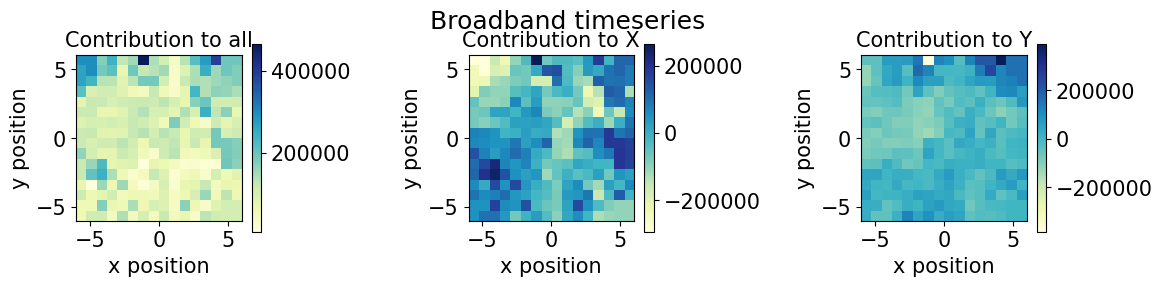

In [54]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
data_map, _ = aopy.visualization.calc_data_map(trd_all, elec_pos[:,0], elec_pos[:,1], (16,16))
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[0])
# im.set_clim(-15, 10)
cb = plt.colorbar(im)
ax[0].set_title('Contribution to all')

data_map, _ = aopy.visualization.calc_data_map(trdx, elec_pos[:,0], elec_pos[:,1], (16,16))
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[1])
# im.set_clim(-15, 10)
cb = plt.colorbar(im)
ax[1].set_title('Contribution to X')

data_map, _ = aopy.visualization.calc_data_map(trdy, elec_pos[:,0], elec_pos[:,1], (16,16))
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[2])
# im.set_clim(-15, 10)
cb = plt.colorbar(im)
ax[2].set_title('Contribution to Y')

fig.tight_layout()
plt.suptitle('Broadband timeseries')
plt.show()

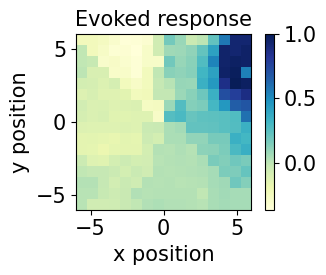

In [55]:
evoked_resp = np.mean(np.sum(np.swapaxes(trial_align_data,0,1),axis=0), axis=0)
fig, ax = plt.subplots(1,1, figsize=(4,3))
data_map, _ = aopy.visualization.calc_data_map(evoked_resp/np.max(evoked_resp), elec_pos[:,0], elec_pos[:,1], (16,16))
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax)
# im.set_clim(, 10)
cb = plt.colorbar(im)
ax.set_title('Evoked response')

fig.tight_layout()
plt.show()

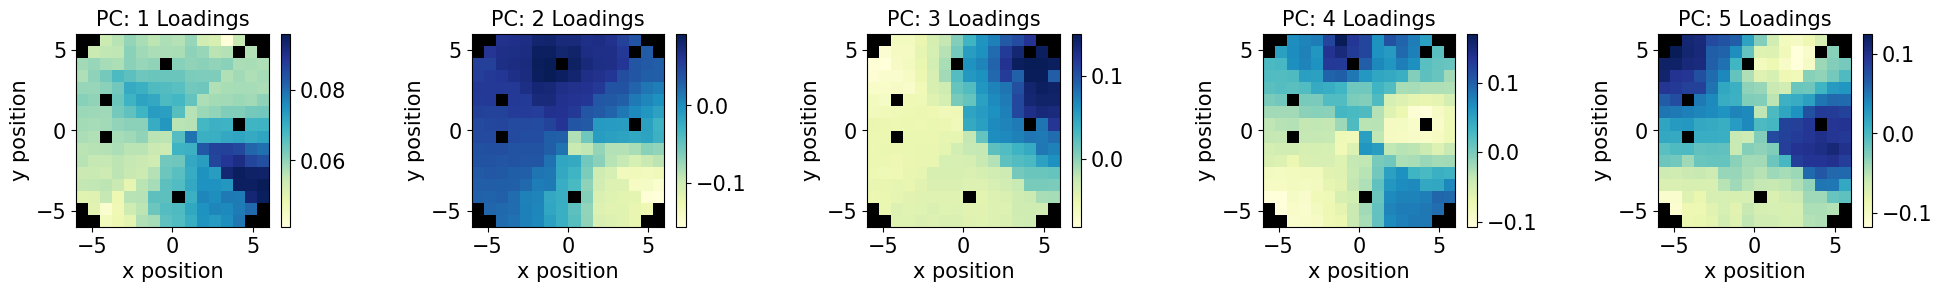

In [56]:
loadings = sklearn.decomposition.PCA().fit(np.vstack(np.swapaxes(trial_align_data,0,1))).components_

npc = 5
fig, ax = plt.subplots(1,npc, figsize=(4*npc,3))
for ipc in range(npc):
    data_map = aopy.visualization.get_data_map(loadings[ipc,:], elec_pos[:,0], elec_pos[:,1])
    im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[ipc])
    # im.set_clim(, 10)
    cb = plt.colorbar(im)
    ax[ipc].set_title(f'PC: {ipc+1} Loadings')

fig.tight_layout()
plt.show()

## Calculate maps for delta power

In [57]:
# bands = [(0.1,4),(4,8),(8,14),(14,30),(30,80),(80,150)]
# nband = len(bands)
# band_name = ['delta','theta','alpha','beta','gamma','hgamma']

In [58]:
start_idx = np.where(t_spec>offset)[0][0]
stop_idx = np.where(t_spec>(offset+time_after))[0][0]
print(start_idx, stop_idx, t_spec[start_idx], t_spec[stop_idx])
deltapower = np.swapaxes(spec_band[:,0,start_idx:stop_idx,:], 0,1)
baseline_deltapower = np.mean(baseline_spec_band[:,0,baseline_start_idx:baseline_stop_idx,:], (0,1))


130 135 0.30000000000000004 0.3500000000000001


In [59]:
import sklearn
scores, test_move, test_pred_move, delta_subspaces, test_label_idx = xval_task_rel_dims(deltapower, np.swapaxes(cursor_traj_mov_on,0,1), labels=target_idx, regularization=None, nfolds=5, alpha=1, smooth_neural_data=False, tavg_neural_data=True, return_test_label_idx=True)

In [60]:
print(np.sum(np.isnan(trd_all)))

0


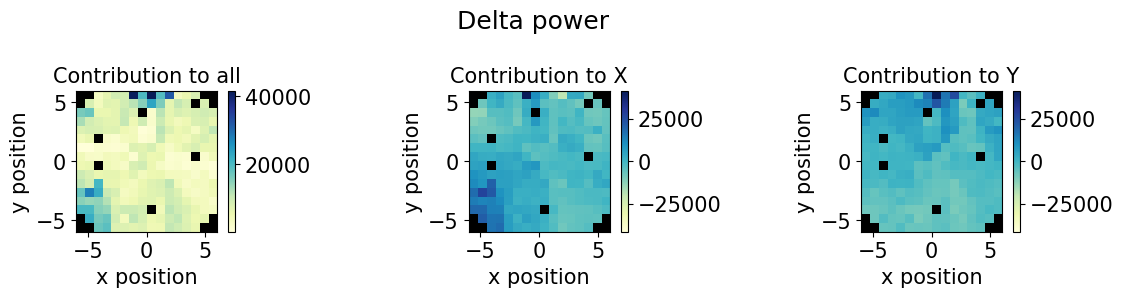

In [61]:
trdx = np.mean(delta_subspaces[:,0,:], axis=1)
trdy = np.mean(delta_subspaces[:,1,:], axis=1)
# trd_all  = np.abs(trdx)+np.abs(trdy)
trd_all  = np.sqrt(trdx**2+trdy**2)

fig, ax = plt.subplots(1,3, figsize=(12,3))
data_map = aopy.visualization.get_data_map(trd_all, elec_pos[:,0], elec_pos[:,1])
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[0])
# im.set_clim(-15, 10)
cb = plt.colorbar(im)
ax[0].set_title('Contribution to all')

data_map = aopy.visualization.get_data_map(trdx, elec_pos[:,0], elec_pos[:,1])
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[1])
im.set_clim(-np.max(np.abs([trdx, trdy])), np.max(np.abs([trdx, trdy])))
cb = plt.colorbar(im)
ax[1].set_title('Contribution to X')

data_map = aopy.visualization.get_data_map(trdy, elec_pos[:,0], elec_pos[:,1])
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[2])
im.set_clim(-np.max(np.abs([trdx, trdy])), np.max(np.abs([trdx, trdy])))
cb = plt.colorbar(im)
ax[2].set_title('Contribution to Y')

plt.suptitle('Delta power')
fig.tight_layout()
plt.show()

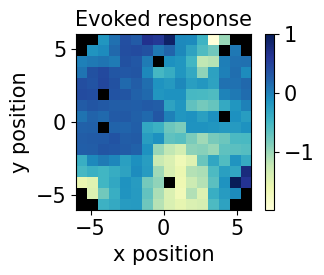

In [62]:
evoked_resp = np.mean(deltapower,axis=(0,1)) - baseline_deltapower
fig, ax = plt.subplots(1,1, figsize=(4,3))
data_map = aopy.visualization.get_data_map(evoked_resp/np.max(evoked_resp), elec_pos[:,0], elec_pos[:,1])
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax)
# im.set_clim(, 10)
cb = plt.colorbar(im)
ax.set_title('Evoked response')

fig.tight_layout()
plt.show()

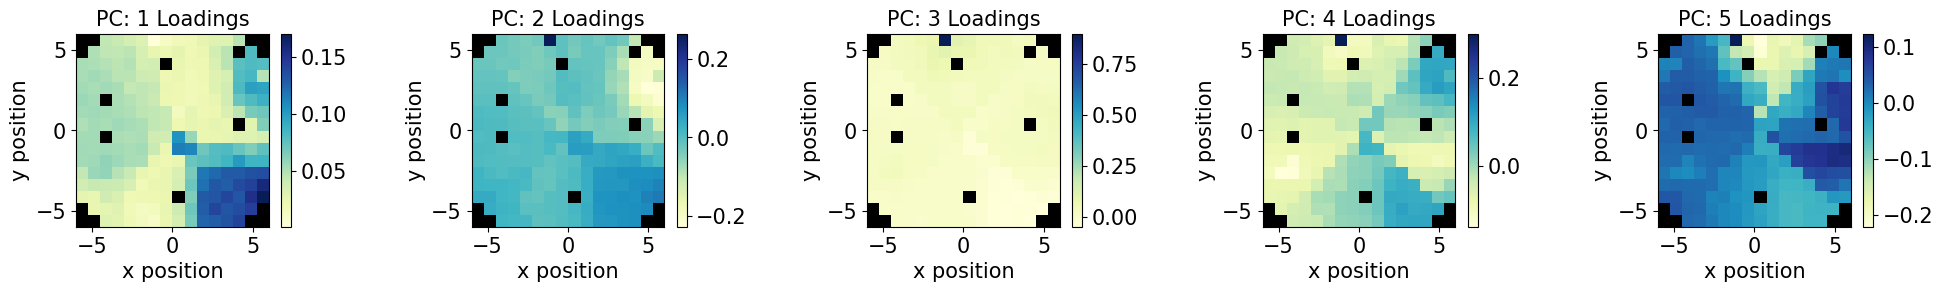

In [63]:
loadings = sklearn.decomposition.PCA().fit(np.vstack(deltapower)).components_

npc = 5
fig, ax = plt.subplots(1,npc, figsize=(4*npc,3))
for ipc in range(npc):
    data_map = aopy.visualization.get_data_map(loadings[ipc,:], elec_pos[:,0], elec_pos[:,1])
    im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[ipc])
    # im.set_clim(, 10)
    cb = plt.colorbar(im)
    ax[ipc].set_title(f'PC: {ipc+1} Loadings')

fig.tight_layout()
plt.show()

## Calculate maps for beta power

In [64]:
start_idx = np.where(t_spec>offset)[0][0]
stop_idx = np.where(t_spec>(offset+time_after))[0][0]
print(start_idx, stop_idx, t_spec[start_idx], t_spec[stop_idx])
betapower = np.swapaxes(spec_band[:,3,start_idx:stop_idx,:], 0,1)
baseline_betapower = np.mean(baseline_spec_band[:,3,baseline_start_idx:baseline_stop_idx,:], (0,1))
import sklearn
scores, test_move, test_pred_move, beta_subspaces, test_label_idx = xval_task_rel_dims(betapower, np.swapaxes(cursor_traj_mov_on,0,1), labels=target_idx, regularization='ridge', nfolds=5, alpha=1, smooth_neural_data=False, tavg_neural_data=True, return_test_label_idx=True)

130 135 0.30000000000000004 0.3500000000000001


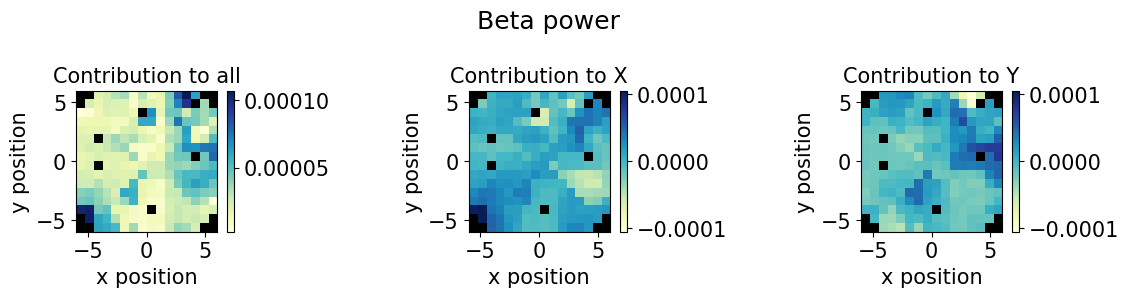

In [65]:
trdx = np.mean(beta_subspaces[:,0,:], axis=1)
trdy = np.mean(beta_subspaces[:,1,:], axis=1)
# trd_all  = np.abs(trdx)+np.abs(trdy)
trd_all  = np.sqrt(trdx**2+trdy**2)

fig, ax = plt.subplots(1,3, figsize=(12,3))
data_map = aopy.visualization.get_data_map(trd_all, elec_pos[:,0], elec_pos[:,1])
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[0])
# im.set_clim(-15, 10)
cb = plt.colorbar(im)
ax[0].set_title('Contribution to all')

data_map = aopy.visualization.get_data_map(trdx, elec_pos[:,0], elec_pos[:,1])
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[1])
im.set_clim(-np.max(np.abs([trdx, trdy])), np.max(np.abs([trdx, trdy])))
cb = plt.colorbar(im)
ax[1].set_title('Contribution to X')

data_map = aopy.visualization.get_data_map(trdy, elec_pos[:,0], elec_pos[:,1])
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[2])
im.set_clim(-np.max(np.abs([trdx, trdy])), np.max(np.abs([trdx, trdy])))
cb = plt.colorbar(im)
ax[2].set_title('Contribution to Y')

plt.suptitle('Beta power')
fig.tight_layout()
plt.show()

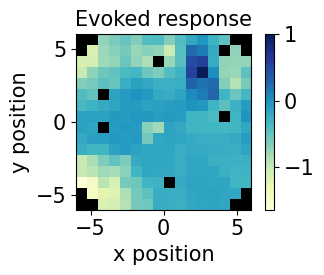

In [66]:
evoked_resp = np.mean(betapower,axis=(0,1)) - baseline_betapower
fig, ax = plt.subplots(1,1, figsize=(4,3))
data_map = aopy.visualization.get_data_map(evoked_resp/np.max(evoked_resp), elec_pos[:,0], elec_pos[:,1])
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax)
# im.set_clim(, 10)
cb = plt.colorbar(im)
ax.set_title('Evoked response')

fig.tight_layout()
plt.show()

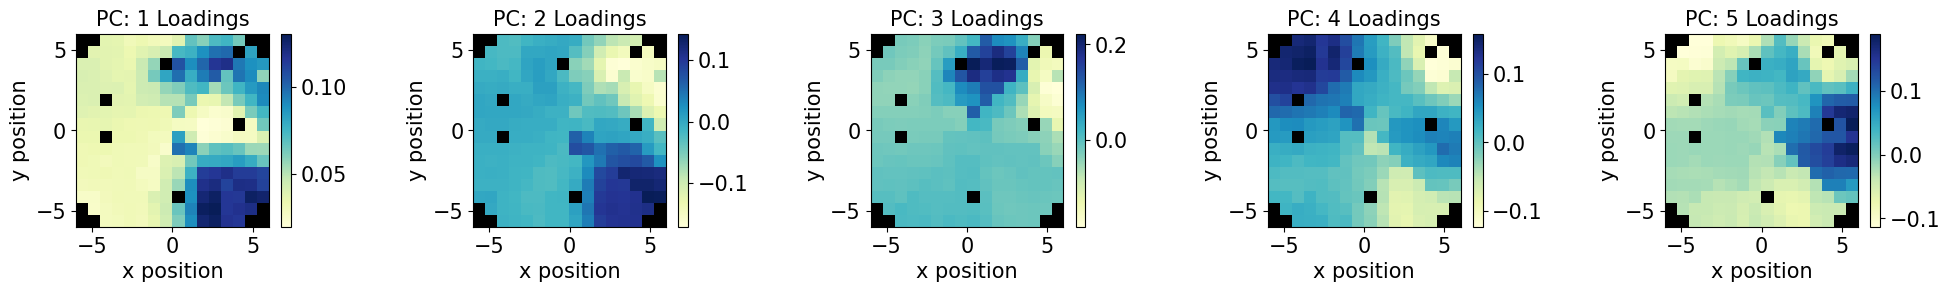

In [67]:
loadings = sklearn.decomposition.PCA().fit(np.vstack(betapower)).components_

npc = 5
fig, ax = plt.subplots(1,npc, figsize=(4*npc,3))
for ipc in range(npc):
    data_map = aopy.visualization.get_data_map(loadings[ipc,:], elec_pos[:,0], elec_pos[:,1])
    im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[ipc])
    # im.set_clim(, 10)
    cb = plt.colorbar(im)
    ax[ipc].set_title(f'PC: {ipc+1} Loadings')

fig.tight_layout()
plt.show()

## Calculate maps for low-gamma power

In [68]:
start_idx = np.where(t_spec>offset)[0][0]
stop_idx = np.where(t_spec>(offset+time_after))[0][0]
print(start_idx, stop_idx, t_spec[start_idx], t_spec[stop_idx])
gammapower = np.swapaxes(spec_band[:,4,start_idx:stop_idx,:], 0,1)
baseline_gammapower = np.mean(baseline_spec_band[:,4,baseline_start_idx:baseline_stop_idx,:], (0,1))
import sklearn
scores, test_move, test_pred_move, gamma_subspaces, test_label_idx = xval_task_rel_dims(gammapower, np.swapaxes(cursor_traj_mov_on,0,1), labels=target_idx, regularization=None, nfolds=5, alpha=1, smooth_neural_data=False, tavg_neural_data=True, return_test_label_idx=True)

130 135 0.30000000000000004 0.3500000000000001


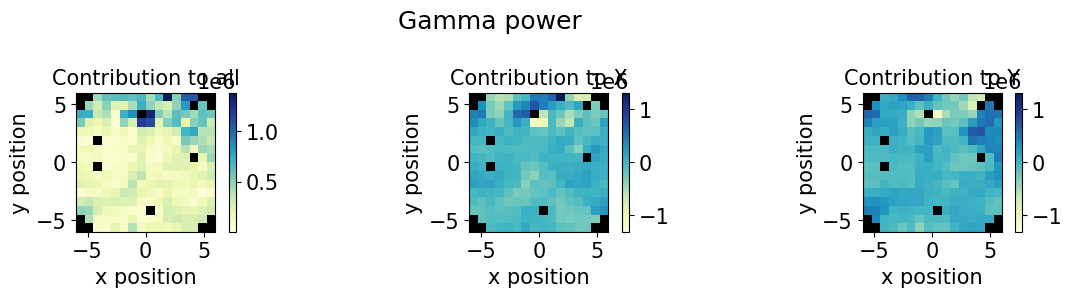

In [69]:
trdx = np.mean(gamma_subspaces[:,0,:], axis=1)
trdy = np.mean(gamma_subspaces[:,1,:], axis=1)
# trd_all  = np.abs(trdx)+np.abs(trdy)
trd_all  = np.sqrt(trdx**2+trdy**2)

fig, ax = plt.subplots(1,3, figsize=(12,3))
data_map = aopy.visualization.get_data_map(trd_all, elec_pos[:,0], elec_pos[:,1])
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[0])
# im.set_clim(-15, 10)
cb = plt.colorbar(im)
ax[0].set_title('Contribution to all')

data_map = aopy.visualization.get_data_map(trdx, elec_pos[:,0], elec_pos[:,1])
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[1])
im.set_clim(-np.max(np.abs([trdx, trdy])), np.max(np.abs([trdx, trdy])))
cb = plt.colorbar(im)
ax[1].set_title('Contribution to X')

data_map = aopy.visualization.get_data_map(trdy, elec_pos[:,0], elec_pos[:,1])
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[2])
im.set_clim(-np.max(np.abs([trdx, trdy])), np.max(np.abs([trdx, trdy])))
cb = plt.colorbar(im)
ax[2].set_title('Contribution to Y')

plt.suptitle('Gamma power')
fig.tight_layout()
plt.show()

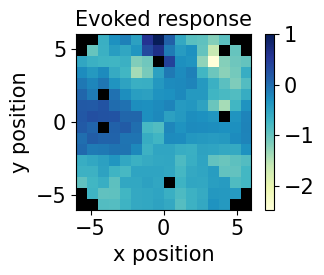

In [70]:
evoked_resp = np.mean(gammapower,axis=(0,1)) - baseline_gammapower
fig, ax = plt.subplots(1,1, figsize=(4,3))
data_map = aopy.visualization.get_data_map(evoked_resp/np.max(evoked_resp), elec_pos[:,0], elec_pos[:,1])
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax)
# im.set_clim(, 10)
cb = plt.colorbar(im)
ax.set_title('Evoked response')

fig.tight_layout()
plt.show()

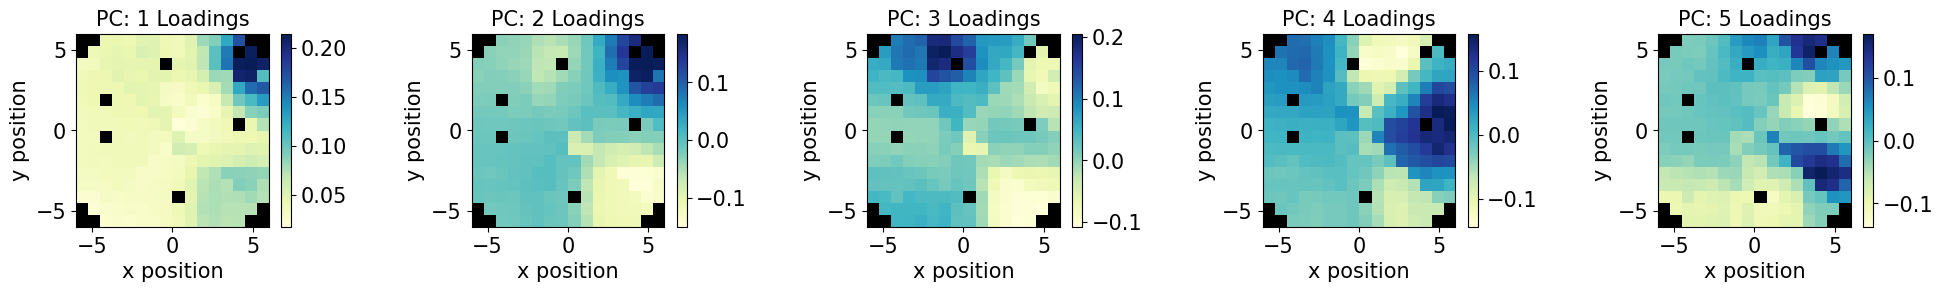

In [71]:
loadings = sklearn.decomposition.PCA().fit(np.vstack(gammapower)).components_

npc = 5
fig, ax = plt.subplots(1,npc, figsize=(4*npc,3))
for ipc in range(npc):
    data_map = aopy.visualization.get_data_map(loadings[ipc,:], elec_pos[:,0], elec_pos[:,1])
    im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[ipc])
    # im.set_clim(, 10)
    cb = plt.colorbar(im)
    ax[ipc].set_title(f'PC: {ipc+1} Loadings')

fig.tight_layout()
plt.show()

## Calculate maps for high-gamma power

In [72]:
baseline_start_idx, baseline_stop_idx, spec_band.shape, start_idx, stop_idx

(1, 51, (800, 6, 201, 238), 130, 135)

In [73]:
hgpower = np.swapaxes(spec_band[:,5,start_idx:stop_idx+1,:], 0,1)
# baseline_hgpower = np.mean(baseline_spec_band[:,5,baseline_start_idx:baseline_stop_idx,:], (0,1))
# baseline_hgpower = np.mean(baseline_spec_band[:,5,:100,:], (0,1))
baseline_hgpower = np.mean(spec_band[:,5,baseline_start_idx:baseline_stop_idx,:], (0,1))
baseline_hgpower_std = np.std(baseline_spec_band[:,5,baseline_start_idx:baseline_stop_idx,:], (0,1))
print(hgpower.shape)
print(cursor_traj_mov_on.shape)
# print(t_spec)

(6, 800, 238)
(800, 400, 2)


In [74]:
print(baseline_start_idx, baseline_stop_idx, t_spec[baseline_start_idx], t_spec[baseline_stop_idx])
# print(baseline_spec_band[:,5,baseline_start_idx:baseline_stop_idx,:].shape)
print(hgpower.shape, baseline_hgpower.shape)

1 51 -0.99 -0.49
(6, 800, 238) (238,)


In [75]:
import sklearn
# scores, test_move, test_pred_move, hg_subspaces, test_label_idx = xval_task_rel_dims(hgpower[:,:798,:], np.swapaxes(cursor_traj_mov_on,0,1)[:,:798,:], labels=target_idx[:798], regularization=None, nfolds=4, alpha=.1, smooth_neural_data=False, tavg_neural_data=True, return_test_label_idx=True)
scores, test_move, test_pred_move, hg_subspaces, test_label_idx = xval_task_rel_dims(hgpower-baseline_hgpower, np.swapaxes(cursor_traj_mov_on,0,1), labels=target_idx, regularization=None, nfolds=4, alpha=.00000000005, smooth_neural_data=True, tavg_neural_data=True, return_test_label_idx=True)

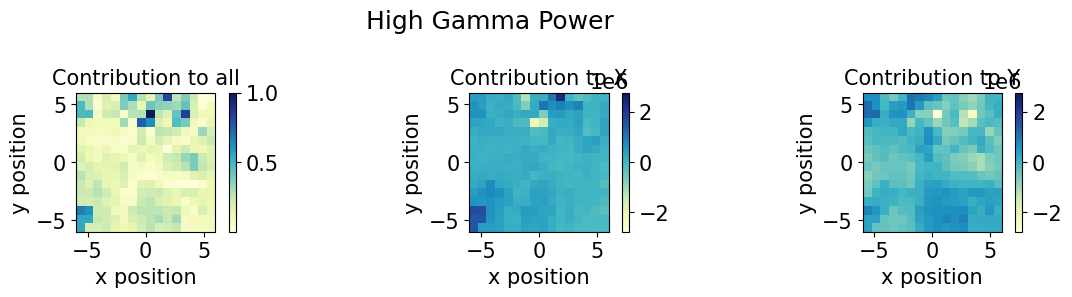

In [76]:
trdx = np.mean(hg_subspaces[:,0,:], axis=1)
trdy = np.mean(hg_subspaces[:,1,:], axis=1)
# trd_all  = np.abs(trdx)+np.abs(trdy)
trd_all  = np.sqrt(trdx**2+trdy**2)
# trd_all = np.abs(trdx - trdy)

fig, ax = plt.subplots(1,3, figsize=(12,3))
data_map, _ = aopy.visualization.calc_data_map(trd_all/np.max(trd_all), elec_pos[:,0], elec_pos[:,1], (16,16))
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[0])
# im.set_clim(, 10)
cb = plt.colorbar(im)
ax[0].set_title('Contribution to all')

data_map, _ = aopy.visualization.calc_data_map(trdx, elec_pos[:,0], elec_pos[:,1], (16, 16))
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[1])
im.set_clim(-np.max(np.abs([trdx, trdy])), np.max(np.abs([trdx, trdy])))
cb = plt.colorbar(im)
ax[1].set_title('Contribution to X')

data_map, _ = aopy.visualization.calc_data_map(trdy, elec_pos[:,0], elec_pos[:,1], (16,16))
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[2])
im.set_clim(-np.max(np.abs([trdx, trdy])), np.max(np.abs([trdx, trdy])))
cb = plt.colorbar(im)
ax[2].set_title('Contribution to Y')

plt.suptitle('High Gamma Power')
fig.tight_layout()
plt.show()

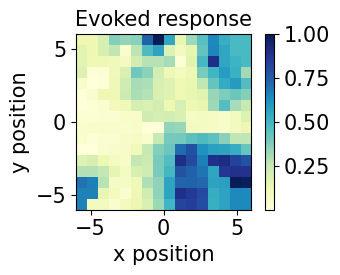

In [77]:
# evoked_resp = np.abs(((np.mean(hgpower,axis=(0,1)) - baseline_hgpower))/baseline_hgpower_std)
evoked_resp = np.abs(((np.mean(hgpower,axis=(0,1)) - baseline_hgpower)))
# evoked_resp = np.abs(((np.mean(hgpower,axis=(0,1)))))
fig, ax = plt.subplots(1,1, figsize=(4,3))
data_map, _ = aopy.visualization.calc_data_map(evoked_resp/np.max(evoked_resp), elec_pos[:,0], elec_pos[:,1], (16,16))
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax)
# im.set_clim(, 10)
cb = plt.colorbar(im)
ax.set_title('Evoked response')

fig.tight_layout()
plt.show()

In [78]:

data_map = aopy.visualization.get_data_map(evoked_resp/np.max(evoked_resp), elec_pos[:,0], elec_pos[:,1])
im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax)
# im.set_clim(0, .70)
cb = plt.colorbar(im)
ax.set_title('Evoked response')

fig.tight_layout()
plt.show()

/tmp/ipykernel_1543689/3821731388.py:4: UserWarning: Adding colorbar to a different Figure <Figure size 400x300 with 3 Axes> than <Figure size 400x300 with 0 Axes> which fig.colorbar is called on.
  cb = plt.colorbar(im)


<Figure size 400x300 with 0 Axes>

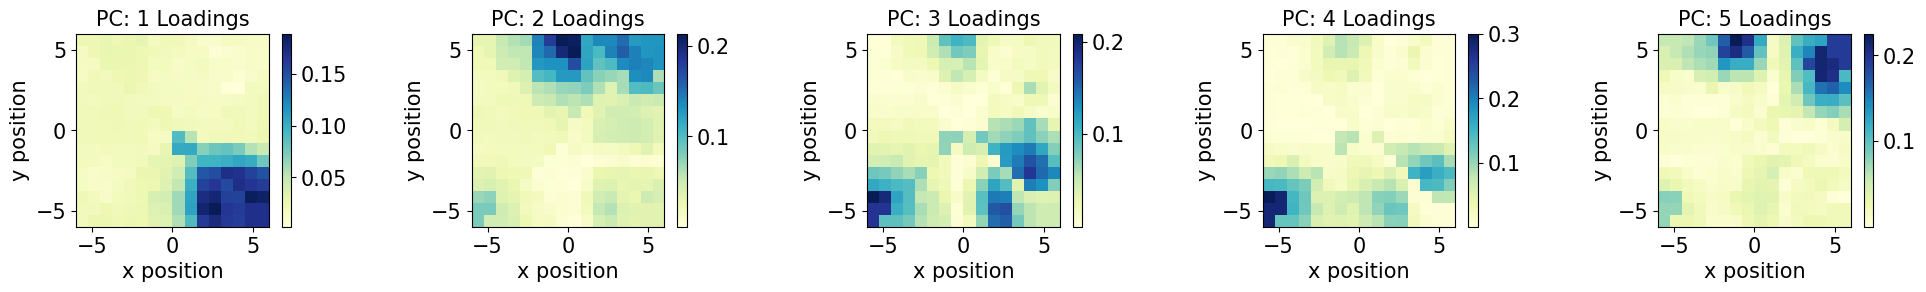

In [79]:
loadings = sklearn.decomposition.PCA().fit(np.vstack(hgpower)).components_
npc = 5
fig, ax = plt.subplots(1,npc, figsize=(4*npc,3))
for ipc in range(npc):
    data_map,_ = aopy.visualization.calc_data_map(np.abs(loadings[ipc,:]), elec_pos[:,0], elec_pos[:,1], (16,16))
    im = aopy.visualization.plot_spatial_map(data_map, elec_pos[:,0], elec_pos[:,1], cmap='YlGnBu', ax=ax[ipc])
    # im.set_clim(, 10)
    cb = plt.colorbar(im)
    ax[ipc].set_title(f'PC: {ipc+1} Loadings')

fig.tight_layout()
plt.show()

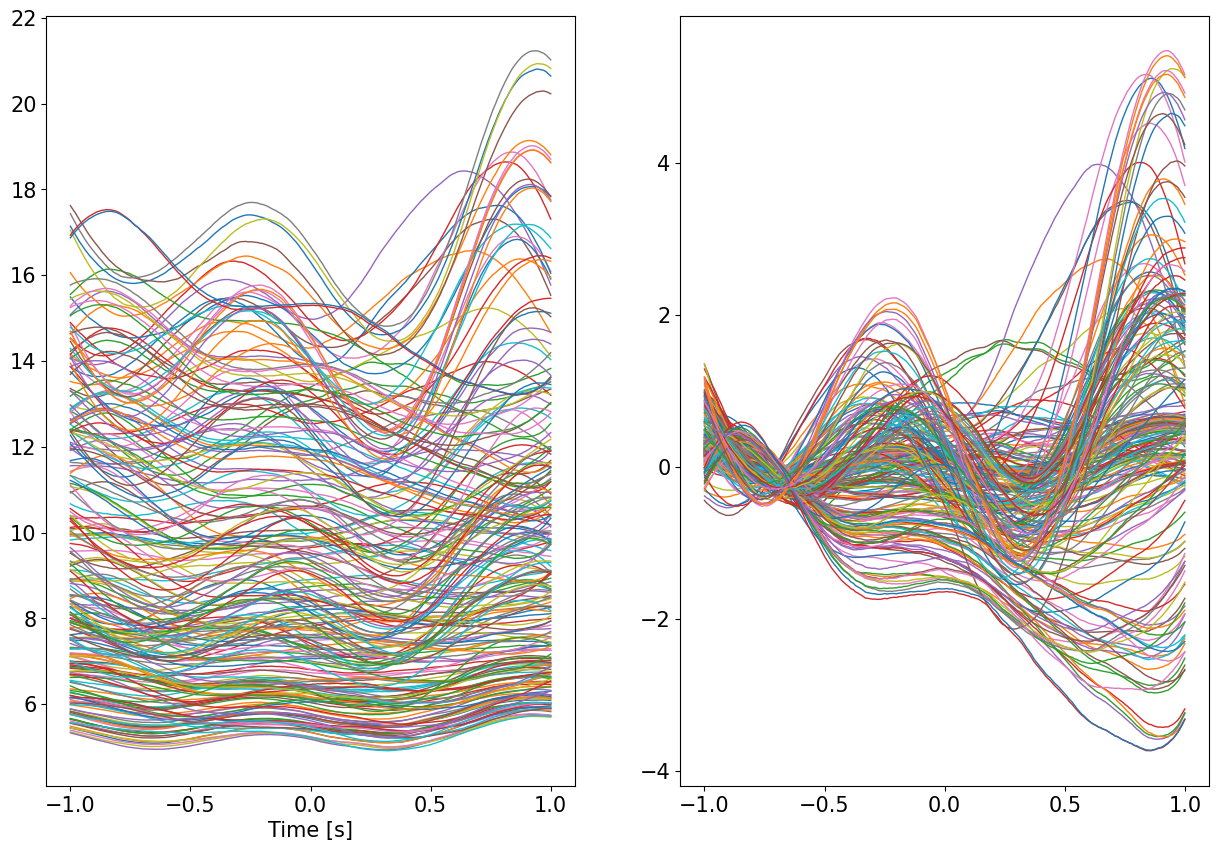

In [80]:
x_pos_sorted_idx = np.argsort(elec_pos[:,0])
y_pos_sorted_idx = np.argsort(elec_pos[:,1])
fig, ax = plt.subplots(1,2,figsize=(15,10))
for ich, ch in enumerate(x_pos_sorted_idx[:]):
    
    ax[0].plot(t_spec, 1e6*(np.mean(spec_band[:,5,:,:], axis=0)[:,ch]))
    ax[0].set(xlabel='Time [s]')
    ax[1].plot(t_spec, 1e6*(np.mean(spec_band[:,5,:,:], axis=0)[:,ch]-baseline_hgpower[ch]))    
    # ax[0].set_yticks(np.arange(len(x_pos_sorted_idx), step=10), elec_pos[x_pos_sorted_idx,0][::10])

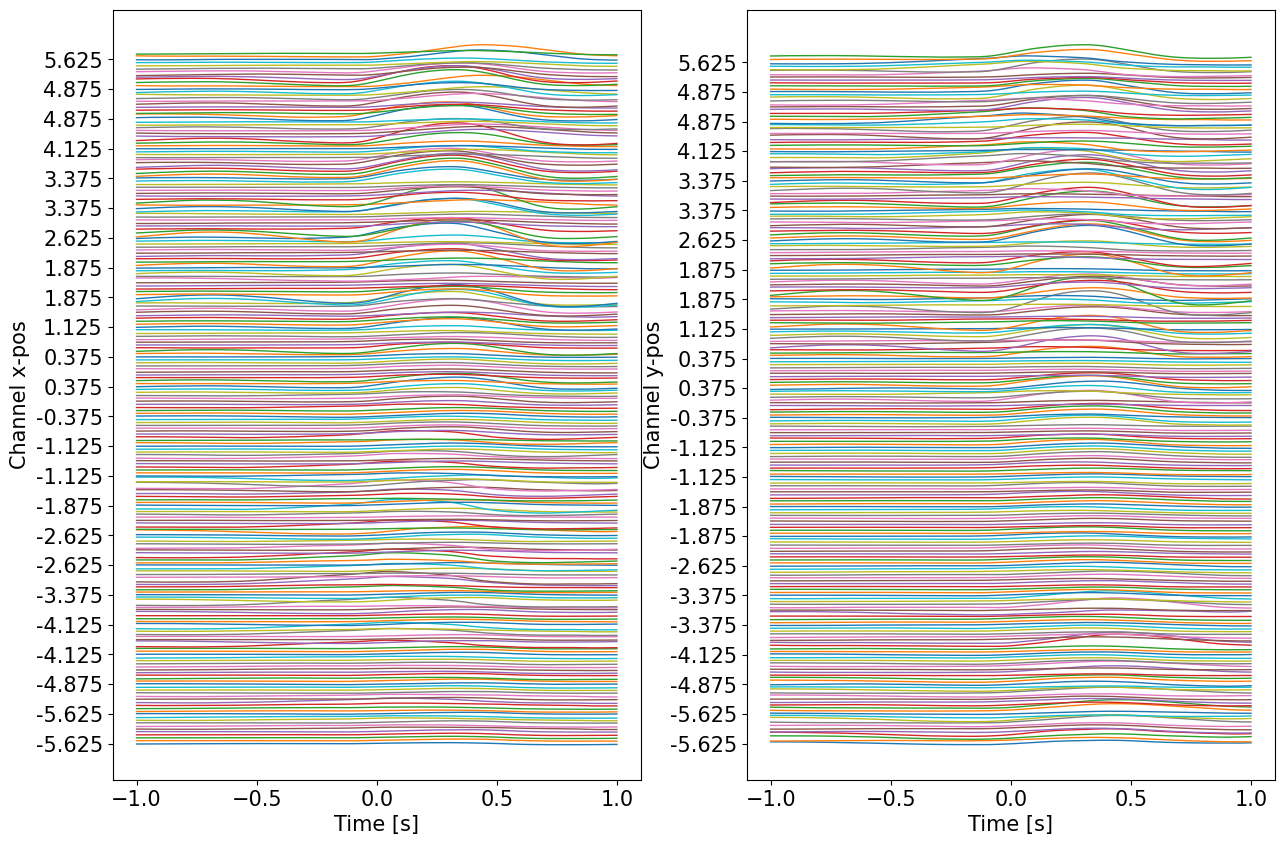

In [129]:
x_pos_sorted_idx = np.argsort(elec_pos[:,0])
y_pos_sorted_idx = np.argsort(elec_pos[:,1])
fig, ax = plt.subplots(1,2,figsize=(15,10))
for ich, ch in enumerate(x_pos_sorted_idx):
    ax[0].plot(t_spec, 1e6*(np.mean(spec_band[:,5,:,:], axis=0)[:,ch]-baseline_hgpower[ch])+ich)
    ax[0].set(xlabel='Time [s]', ylabel='Channel x-pos')
    ax[0].set_yticks(np.arange(len(x_pos_sorted_idx), step=10), elec_pos[x_pos_sorted_idx,0][::10])
for ich, ch in enumerate(y_pos_sorted_idx):   
    ax[1].plot(t_spec, 1e6*(np.mean(spec_band[:,5,:,:], axis=0)[:,ch]-baseline_hgpower[ch])+ich)
    ax[1].set(xlabel='Time [s]', ylabel='Channel y-pos')
    ax[1].set_yticks(np.arange(len(y_pos_sorted_idx), step=10), elec_pos[y_pos_sorted_idx,1][::10])

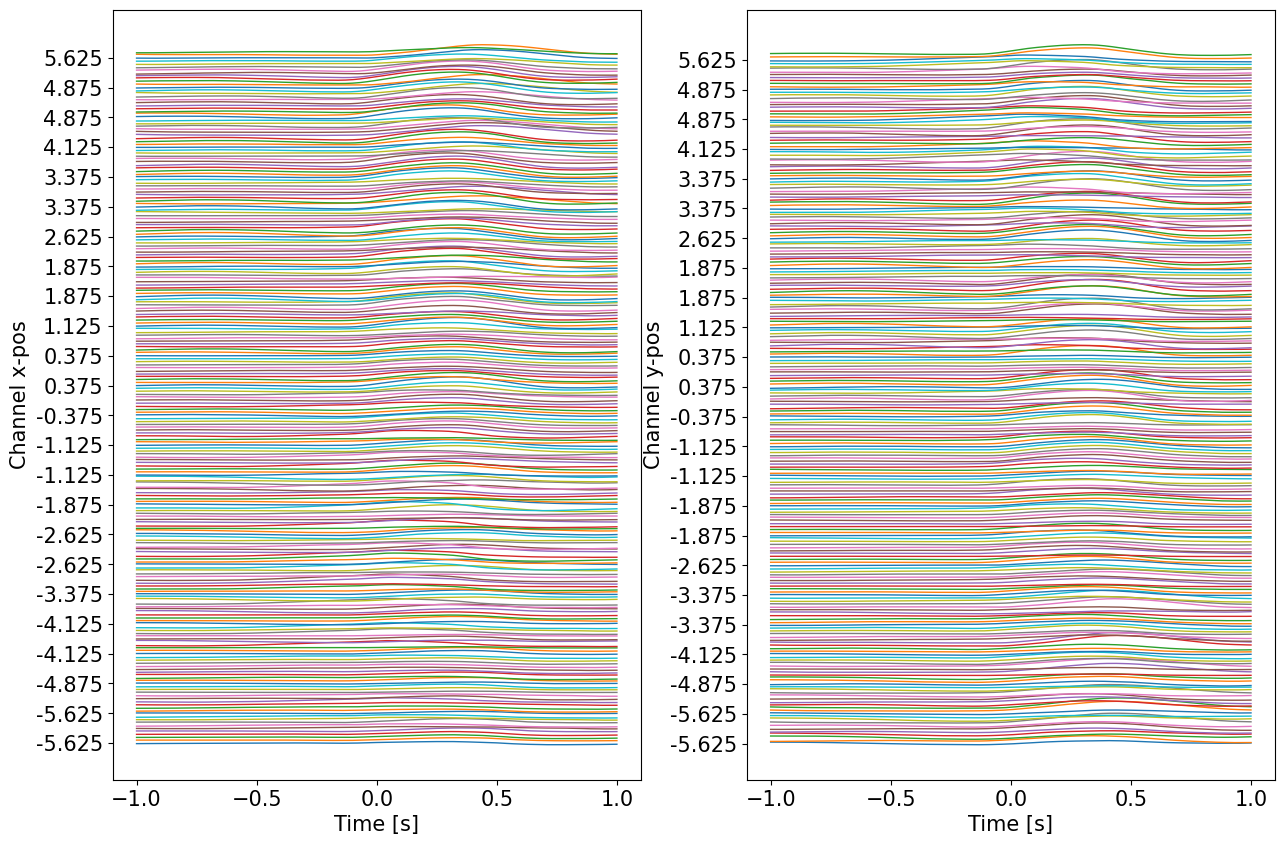

In [130]:
# zscored to baseline
x_pos_sorted_idx = np.argsort(elec_pos[:,0])
y_pos_sorted_idx = np.argsort(elec_pos[:,1])
fig, ax = plt.subplots(1,2,figsize=(15,10))
for ich, ch in enumerate(x_pos_sorted_idx):
    ax[0].plot(t_spec, ((np.mean(spec_band[:,5,:,:], axis=0)[:,ch]-baseline_hgpower[ch])/baseline_hgpower_std[ch])+ich)
    ax[0].set(xlabel='Time [s]', ylabel='Channel x-pos')
    ax[0].set_yticks(np.arange(len(x_pos_sorted_idx), step=10), elec_pos[x_pos_sorted_idx,0][::10])
for ich, ch in enumerate(y_pos_sorted_idx):   
    ax[1].plot(t_spec, (np.mean(spec_band[:,5,:,:], axis=0)[:,ch]-baseline_hgpower[ch])/baseline_hgpower_std[ch]+ich)
    ax[1].set(xlabel='Time [s]', ylabel='Channel y-pos')
    ax[1].set_yticks(np.arange(len(y_pos_sorted_idx), step=10), elec_pos[y_pos_sorted_idx,1][::10])

In [261]:
# Save
band_idx=5
# np.savez(f'/media/moor-data/results/Ryan/neuropixel_targeting/ecog_decoding_maps/{subject}_{flag}_LinRegAll_{band_name[band_idx]}', da=trd_all, elec_pos=elec_pos)
np.savez(f'/media/moor-data/results/Ryan/neuropixel_targeting/ecog_decoding_maps/{subject}_{flag}_LinRegAll_{band_name[band_idx]}', da=evoked_resp, elec_pos=elec_pos)
# np.savez(f'/media/moor-data/results/Ryan/neuropixel_targeting/ecog_decoding_maps/{subject}_{flag}_LinRegAll_{band_name[band_idx]}', da=np.abs(loadings[0,:]), elec_pos=elec_pos)
np.savez(f'/media/moor-data/results/Ryan/neuropixel_targeting/ecog_decoding_maps/{subject}_{flag}_LinRegX_{band_name[band_idx]}', da=trdx, elec_pos=elec_pos)
np.savez(f'/media/moor-data/results/Ryan/neuropixel_targeting/ecog_decoding_maps/{subject}_{flag}_LinRegY_{band_name[band_idx]}', da=trdy, elec_pos=elec_pos)

## Calculate maps for spike-band power

In [ ]:
# offset = .25
# start_idx = np.where(t_spec>offset)[0][0]
# stop_idx = np.where(t_spec>(offset+time_after))[0][0]
# print(start_idx, stop_idx, t_spec[start_idx], t_spec[stop_idx])
# hgpower = np.swapaxes(spec_band[:,5,start_idx:stop_idx,:], 0,1)
# print(hgpower.shape)